Descriptive Statistics:
count    8.198467e+07
mean     2.709088e+03
std      6.358931e+03
min      3.700000e+00
25%      1.066000e+02
50%      5.734000e+02
75%      2.755200e+03
max      7.041230e+04
Name: marketcap_first_day, dtype: float64

Skewness: 5.97
Kurtosis: 50.75


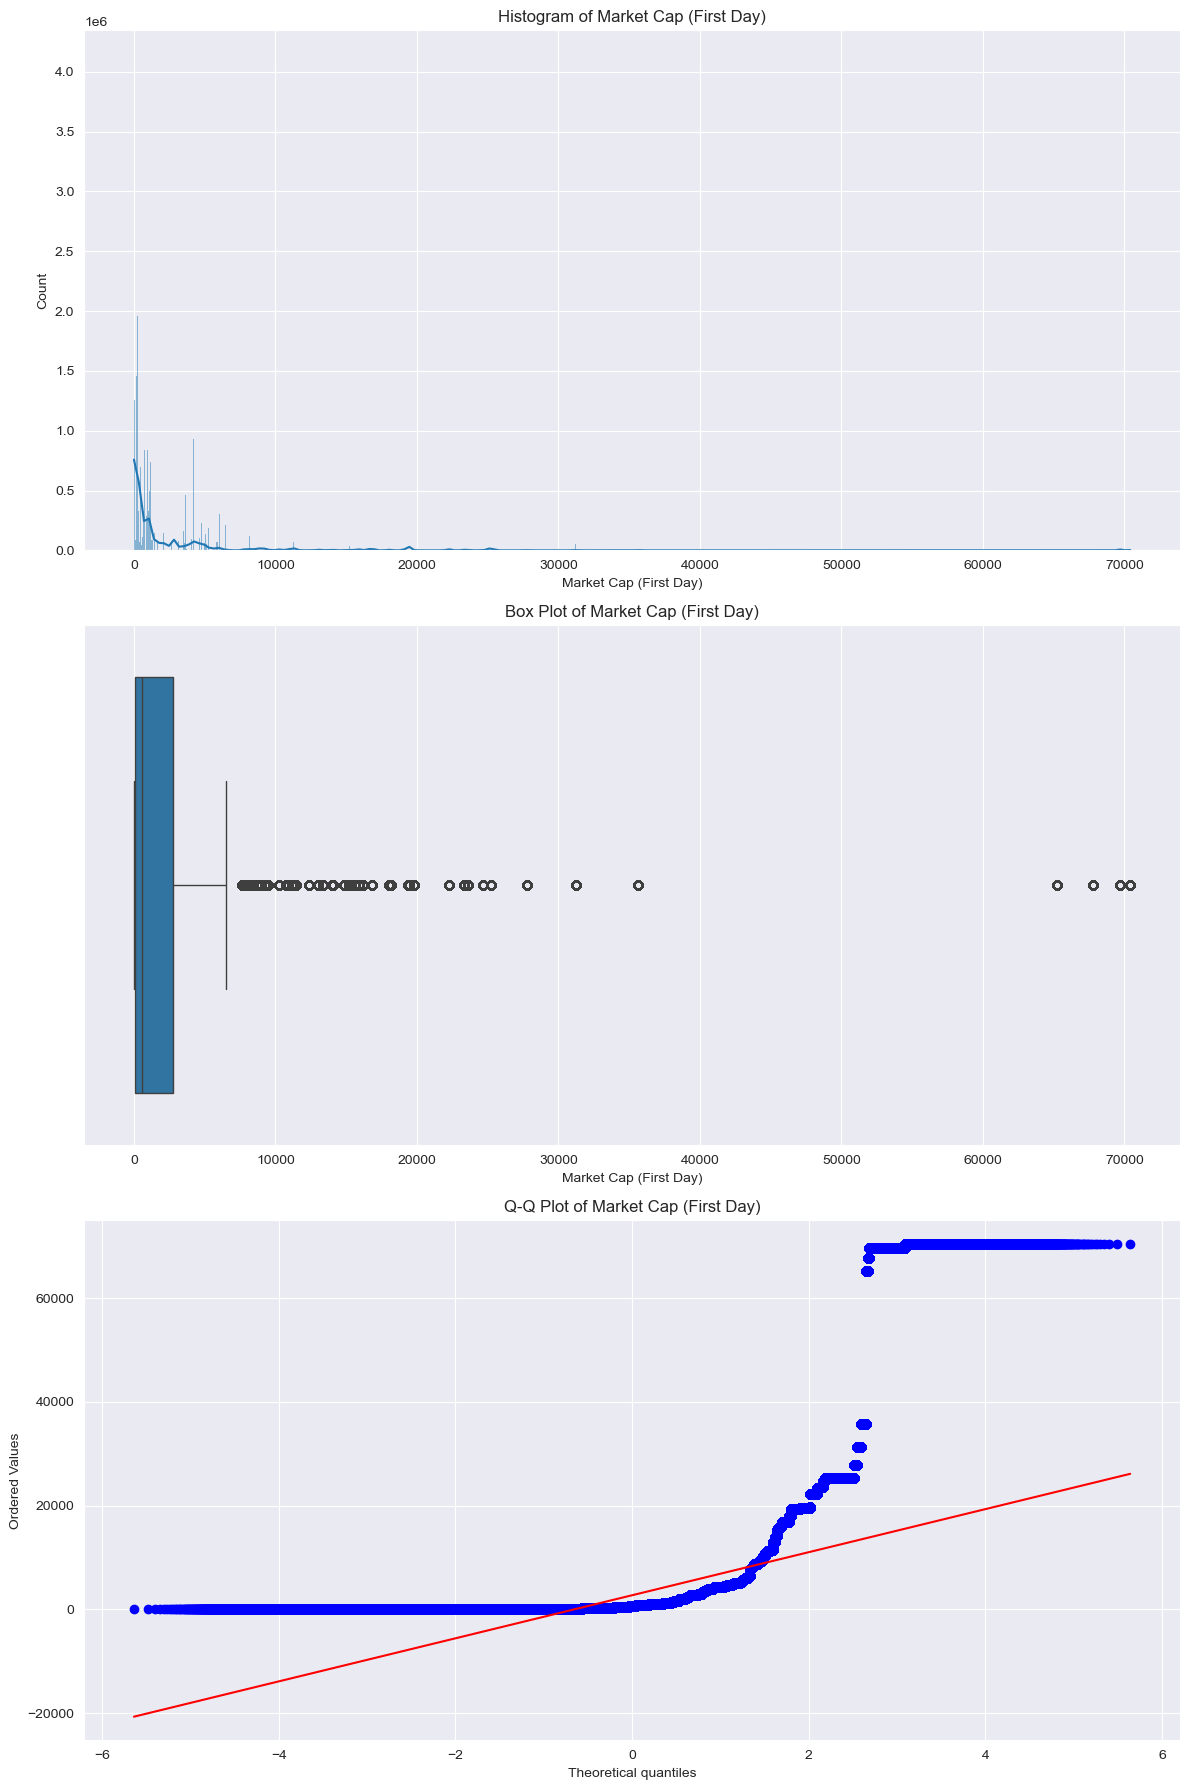


Percentage of data within 1 standard deviation: 92.42%
Percentage of data within 2 standard deviations: 95.08%
Percentage of data within 3 standard deviations: 97.82%

Number of zero values: 0
Number of negative values: 0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set the file path
file_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File '{file_path}' not found. Please check the file path.")
    exit()

# Read the target variable
target_df = pd.read_parquet(file_path)

# Descriptive statistics
desc_stats = target_df['marketcap_first_day'].describe()
print("Descriptive Statistics:")
print(desc_stats)

# Additional statistics
skewness = target_df['marketcap_first_day'].skew()
kurtosis = target_df['marketcap_first_day'].kurtosis()
print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

# Create a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# Histogram
sns.histplot(data=target_df, x='marketcap_first_day', kde=True, ax=ax1)
ax1.set_title('Histogram of Market Cap (First Day)')
ax1.set_xlabel('Market Cap (First Day)')

# Box plot
sns.boxplot(x=target_df['marketcap_first_day'], ax=ax2)
ax2.set_title('Box Plot of Market Cap (First Day)')
ax2.set_xlabel('Market Cap (First Day)')

# Q-Q plot
stats.probplot(target_df['marketcap_first_day'], dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot of Market Cap (First Day)')

plt.tight_layout()
plt.savefig('marketcap_first_day_analysis.png')
plt.show()

# Calculate the percentage of data within 1, 2, and 3 standard deviations
mean = target_df['marketcap_first_day'].mean()
std = target_df['marketcap_first_day'].std()

within_1_std = ((target_df['marketcap_first_day'] >= mean - std) &
                (target_df['marketcap_first_day'] <= mean + std)).mean()
within_2_std = ((target_df['marketcap_first_day'] >= mean - 2*std) &
                (target_df['marketcap_first_day'] <= mean + 2*std)).mean()
within_3_std = ((target_df['marketcap_first_day'] >= mean - 3*std) &
                (target_df['marketcap_first_day'] <= mean + 3*std)).mean()

print(f"\nPercentage of data within 1 standard deviation: {within_1_std:.2%}")
print(f"Percentage of data within 2 standard deviations: {within_2_std:.2%}")
print(f"Percentage of data within 3 standard deviations: {within_3_std:.2%}")

# Check for zero and negative values
zero_count = (target_df['marketcap_first_day'] == 0).sum()
negative_count = (target_df['marketcap_first_day'] < 0).sum()

print(f"\nNumber of zero values: {zero_count}")
print(f"Number of negative values: {negative_count}")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import pyarrow as pa
import os

# Set the file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Check if the files exist
for path in [features_path, target_path]:
    if not os.path.exists(path):
        print(f"File '{path}' not found. Please check the file path.")
        exit()

# Read the target variable (assuming it's small enough to fit in memory)
target_df = pd.read_parquet(target_path)

# Get the list of columns from the features file
feature_columns = pq.read_schema(features_path).names

print("Columns in the dataset:")
print(feature_columns + target_df.columns.tolist())

# Select numerical columns for analysis
parquet_file = pq.ParquetFile(features_path)
schema = parquet_file.schema_arrow
numerical_features = [field.name for field in schema if pa.types.is_floating(field.type) or pa.types.is_integer(field.type)]

print(f"\nNumber of numerical features: {len(numerical_features)}")
print("First few numerical features:", numerical_features[:5])

# Initialize dictionaries to store results
correlations = {feature: 0 for feature in numerical_features}
row_count = 0

# Process the data in chunks
chunksize = 100000  # Adjust this based on your available memory
for batch in parquet_file.iter_batches(batch_size=chunksize, columns=numerical_features):
    chunk = batch.to_pandas()

    # Merge with target variable
    merged_chunk = pd.concat([chunk, target_df.iloc[row_count:row_count+len(chunk)]], axis=1)
    row_count += len(chunk)

    # Calculate correlations
    chunk_correlations = merged_chunk[numerical_features + ['marketcap_first_day']].corr()['marketcap_first_day']
    for feature, corr in chunk_correlations.items():
        if feature != 'marketcap_first_day':
            correlations[feature] += corr * len(chunk)

    print(f"Processed {row_count} rows")

    # Check for NaN values
    if chunk_correlations.isna().any():
        print("Warning: NaN values found in correlations")
        print(chunk_correlations[chunk_correlations.isna()])

    # Break after processing first chunk (for debugging)
    break

# Average the correlations
for feature in correlations:
    correlations[feature] /= row_count

# Sort correlations
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]) if not np.isnan(x[1]) else 0, reverse=True)

# Print results
print("\nTop 10 Correlations with Market Cap (First Day):")
for feature, corr in sorted_correlations[:10]:
    print(f"{feature}: {corr:.4f}")

# Print some statistics about the data
print("\nData Statistics:")
print(merged_chunk.describe())

# Check for infinite values
inf_count = np.isinf(merged_chunk[numerical_features]).sum().sum()
print(f"\nNumber of infinite values: {inf_count}")

# Check for NaN values
nan_count = merged_chunk[numerical_features].isna().sum().sum()
print(f"Number of NaN values: {nan_count}")

print("\nAnalysis complete.")

Columns in the dataset:
['investmentsc', 'investments', 'ncfo', 'revenue', 'fcf', 'netinc', 'asset_utilization', 'ebitda', 'log_revenue', 'fcfps', 'fcf_to_assets', 'investmentsnc', 'log_assets', 'asset_turnover', 'ps', 'ncfinv', 'equity', 'roa', 'assets', 'net_profit_margin', 'fcf_to_revenue', 'evebit', 'capex_to_revenue', 'gross_margin', 'cash_conversion_cycle', 'assetsc', 'evebitda', 'cash_to_assets', 'ros', 'quick_ratio', 'dividend_yield_to_price', 'inventory_turnover', 'price_to_tangible_book', 'roic', 'operating_margin', 'cashneq', 'roe', 'liabilities', 'payout_ratio', 'ncfbus', 'ncfx', 'operating_expense_ratio', 'gross_profit_to_assets', 'ncff', 'earnings_yield', 'pb_missing', 'pe_missing', 'marketcap_missing', 'interest_coverage', 'capex', 'debt_to_equity', 'current_ratio', 'pb', 'investments_ncfo', 'revenue_asset_utilization', 'investmentsc_squared', 'investments_squared', 'ncfo_squared', 'revenue_squared', 'fcf_squared', 'netinc_squared', 'marketcap_first_day']

Number of nume

In [14]:
import pandas as pd
import pyarrow.parquet as pq

target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read the entire target variable
target_df = pd.read_parquet(target_path)

print("Target variable statistics:")
print(target_df['marketcap_first_day'].describe())

print("\nUnique values:")
print(target_df['marketcap_first_day'].value_counts())

if target_df['marketcap_first_day'].nunique() == 1:
    print("\nWarning: 'marketcap_first_day' has only one unique value!")

Target variable statistics:
count    8.198467e+07
mean     2.709088e+03
std      6.358931e+03
min      3.700000e+00
25%      1.066000e+02
50%      5.734000e+02
75%      2.755200e+03
max      7.041230e+04
Name: marketcap_first_day, dtype: float64

Unique values:
marketcap_first_day
4382.2    1235718
1001.6     862488
1911.6     808020
35.2       769318
221.4      760500
           ...   
48.8         1944
2922.6       1764
6491.1       1296
129.7         324
549.5         256
Name: count, Length: 529, dtype: int64


In [16]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa

# Set the file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read the target variable
target_df = pd.read_parquet(target_path)

# Log transform the target variable
target_df['log_marketcap_first_day'] = np.log1p(target_df['marketcap_first_day'])

# Get the list of columns from the features file
parquet_file = pq.ParquetFile(features_path)
schema = parquet_file.schema_arrow
numerical_features = [field.name for field in schema if pa.types.is_floating(field.type) or pa.types.is_integer(field.type)]

# Initialize variables to store results
correlations = {feature: 0 for feature in numerical_features}
row_count = 0
nan_counts = {feature: 0 for feature in numerical_features}
inf_counts = {feature: 0 for feature in numerical_features}

# Process the data in chunks
chunksize = 1000000  # Adjust this based on your available memory
for batch in parquet_file.iter_batches(batch_size=chunksize, columns=numerical_features):
    chunk = batch.to_pandas()

    # Merge with target variable
    merged_chunk = pd.concat([chunk, target_df.iloc[row_count:row_count+len(chunk)]], axis=1)
    row_count += len(chunk)

    # Count NaN and Inf values
    for feature in numerical_features:
        nan_counts[feature] += merged_chunk[feature].isna().sum()
        inf_counts[feature] += np.isinf(merged_chunk[feature]).sum()

    # Calculate correlations
    chunk_correlations = merged_chunk[numerical_features + ['log_marketcap_first_day']].corr()['log_marketcap_first_day']
    for feature, corr in chunk_correlations.items():
        if feature != 'log_marketcap_first_day':
            correlations[feature] += corr * len(chunk)

    print(f"Processed {row_count} rows")

    # Print some diagnostic information for the first chunk
    if row_count == chunksize:
        print("\nDiagnostic information for the first chunk:")
        print(merged_chunk.describe())
        print("\nCorrelations for the first chunk:")
        print(chunk_correlations)

# Average the correlations
for feature in correlations:
    correlations[feature] /= row_count

# Sort correlations
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]) if not np.isnan(x[1]) else 0, reverse=True)

# Print results
print("\nTop 10 Correlations with Log Market Cap (First Day):")
for feature, corr in sorted_correlations[:10]:
    print(f"{feature}: {corr:.4f}")

print("\nFeatures with NaN values:")
for feature, count in nan_counts.items():
    if count > 0:
        print(f"{feature}: {count}")

print("\nFeatures with Inf values:")
for feature, count in inf_counts.items():
    if count > 0:
        print(f"{feature}: {count}")

print("\nAnalysis complete.")

Processed 1000000 rows

Diagnostic information for the first chunk:
         investmentsc     investments            ncfo         revenue  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean         4.856820       13.083223        0.764185        7.448930   
std         12.548902       30.577296        4.756430       10.865120   
min         -1.354057       -3.185049      -15.324445       -0.684822   
25%         -1.354057       -3.184963       -0.396170       -0.030409   
50%         -1.345235       -2.804594        0.291302        1.259506   
75%          3.373059        7.518888        1.045387       11.678440   
max         48.886558      128.037274       20.793339       35.915116   

                  fcf          netinc  asset_utilization          ebitda  \
count  1000000.000000  1000000.000000     1000000.000000  1000000.000000   
mean        -0.527534        2.226361           0.814257        2.544558   
std          6.312887        3.935749         

Top 10 Correlations with Log Market Cap (First Day):
log_marketcap_first_day      1.000000
revenue_asset_utilization    0.780515
investmentsc                 0.656284
investmentsc_squared         0.639265
investments                  0.595753
investments_squared          0.592412
ncfo                         0.573966
investments_ncfo             0.541555
fcf_to_assets                0.539820
revenue                      0.535910
ps                          -0.520508
Name: log_marketcap_first_day, dtype: float64


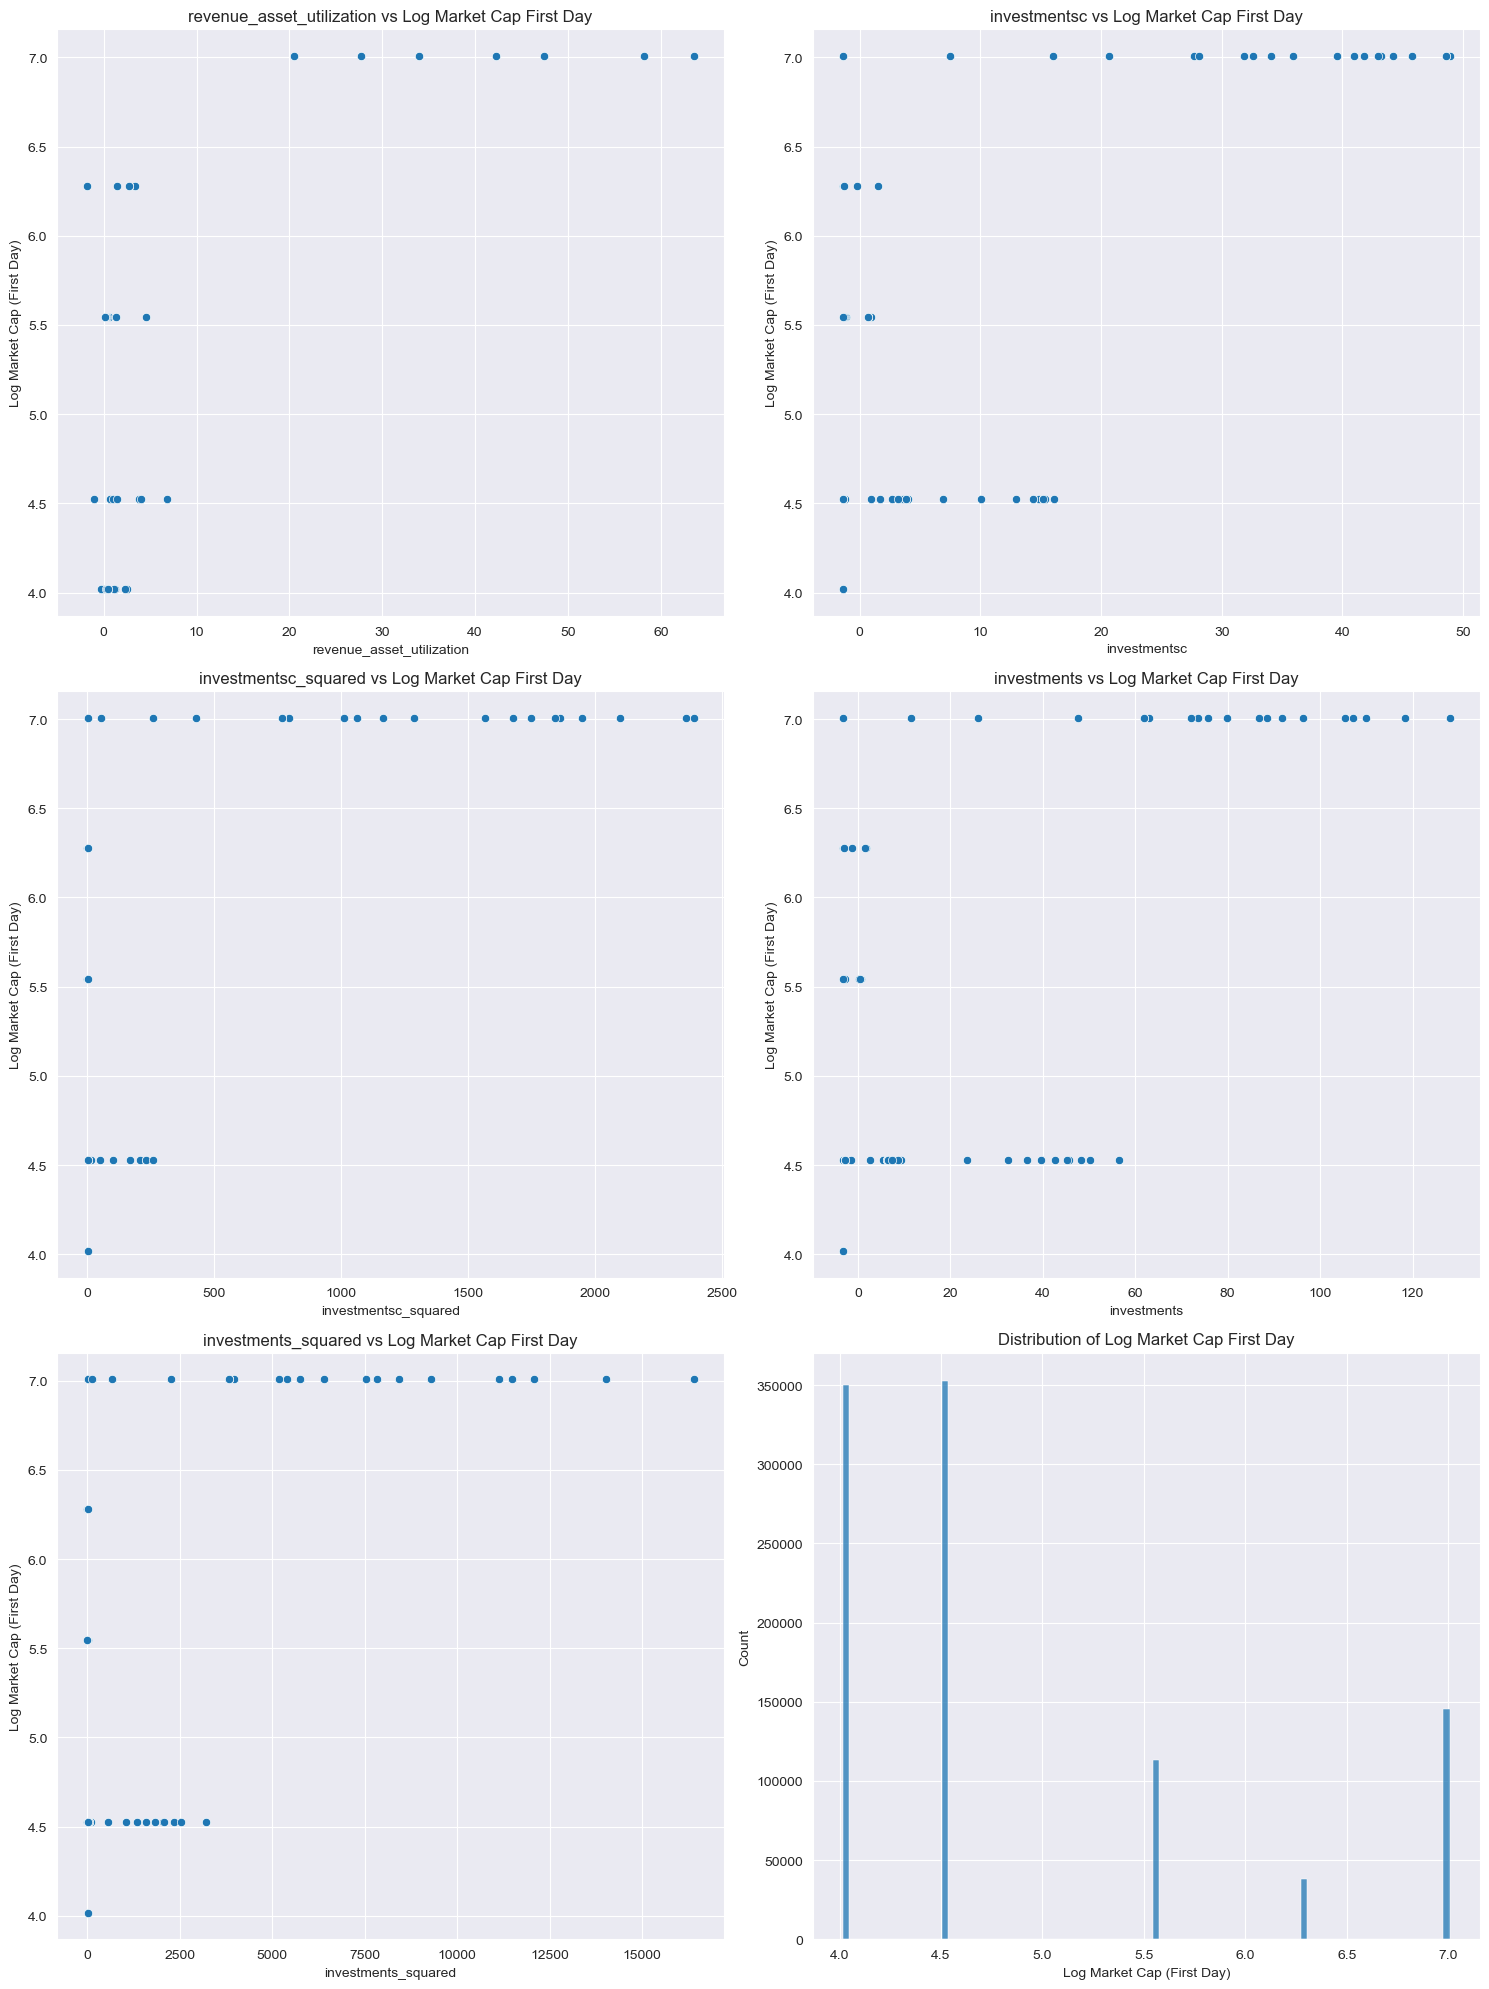


Analysis complete. Check 'top_5_features_analysis.png' for visualizations.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import pyarrow as pa

# Set the file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read the first 1,000,000 rows of features
features_df = pd.read_parquet(features_path, engine='pyarrow').head(1000000)

# Read the corresponding target variable rows
target_df = pd.read_parquet(target_path, engine='pyarrow').head(1000000)

# Log transform the target variable
target_df['log_marketcap_first_day'] = np.log1p(target_df['marketcap_first_day'])

# Merge features and target
merged_df = pd.concat([features_df, target_df['log_marketcap_first_day']], axis=1)

# Calculate correlations
correlations = merged_df.corr()['log_marketcap_first_day'].sort_values(key=abs, ascending=False)

# Print top 10 correlations
print("Top 10 Correlations with Log Market Cap (First Day):")
print(correlations.head(11))  # 11 because it includes the correlation with itself

# Create plots for top 5 correlated features
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
axs = axs.ravel()

for i, feature in enumerate(correlations.index[1:6]):  # Skip the first one (correlation with itself)
    sns.scatterplot(x=feature, y='log_marketcap_first_day', data=merged_df.sample(n=10000), ax=axs[i])
    axs[i].set_title(f'{feature} vs Log Market Cap First Day')
    axs[i].set_ylabel('Log Market Cap (First Day)')

# Distribution of log market cap
sns.histplot(merged_df['log_marketcap_first_day'], ax=axs[5])
axs[5].set_title('Distribution of Log Market Cap First Day')
axs[5].set_xlabel('Log Market Cap (First Day)')

plt.tight_layout()
plt.show()
plt.savefig('top_5_features_analysis.png')
plt.close()

print("\nAnalysis complete. Check 'top_5_features_analysis.png' for visualizations.")

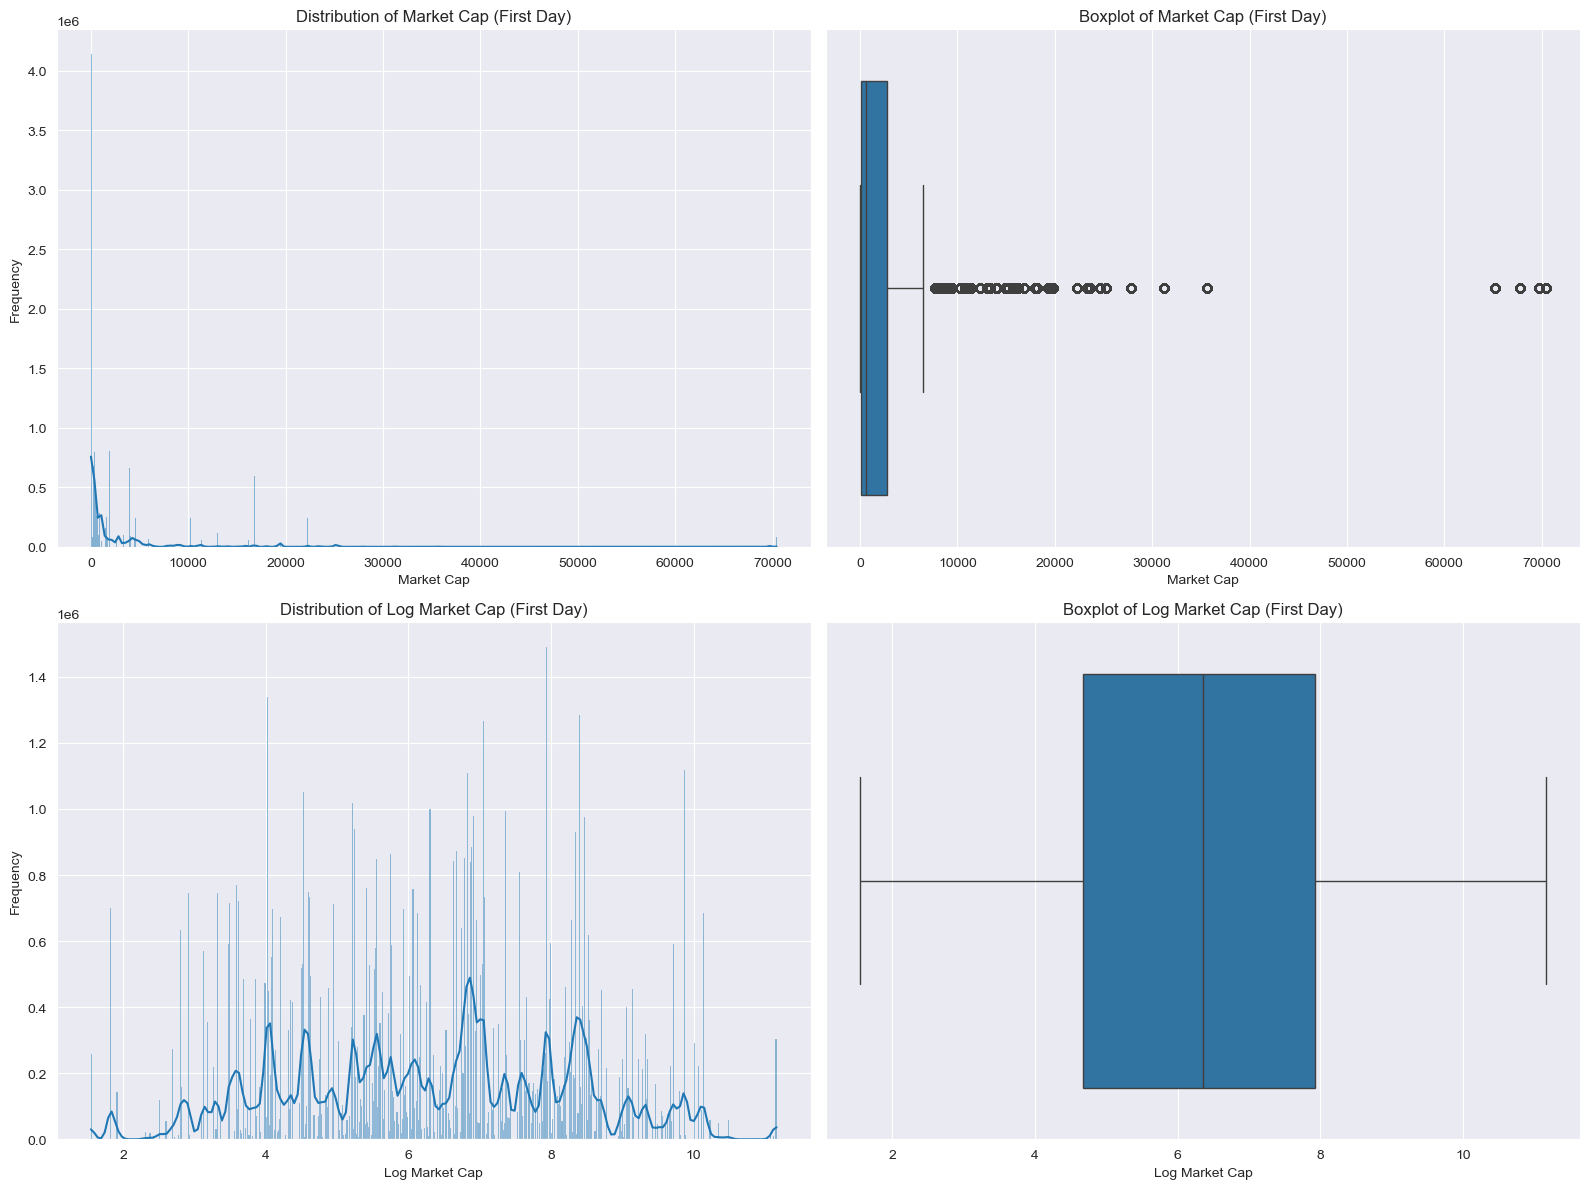

Summary Statistics for Market Cap (First Day):
count    8.198467e+07
mean     2.709088e+03
std      6.358931e+03
min      3.700000e+00
25%      1.066000e+02
50%      5.734000e+02
75%      2.755200e+03
max      7.041230e+04
Name: marketcap_first_day, dtype: float64

Summary Statistics for Log Market Cap (First Day):
count    8.198467e+07
mean     6.302299e+00
std      1.947870e+00
min      1.547563e+00
25%      4.678421e+00
50%      6.353326e+00
75%      7.921608e+00
max      1.116214e+01
Name: log_marketcap_first_day, dtype: float64

Analysis complete. Check 'marketcap_distribution.png' for visualizations.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the file path
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read the target variable
target_df = pd.read_parquet(target_path)

# Create log-transformed variable
target_df['log_marketcap_first_day'] = np.log1p(target_df['marketcap_first_day'])

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(16, 12))

# Original Market Cap
sns.histplot(target_df['marketcap_first_day'], kde=True, ax=ax1[0])
ax1[0].set_title('Distribution of Market Cap (First Day)')
ax1[0].set_xlabel('Market Cap')
ax1[0].set_ylabel('Frequency')

sns.boxplot(x=target_df['marketcap_first_day'], ax=ax1[1])
ax1[1].set_title('Boxplot of Market Cap (First Day)')
ax1[1].set_xlabel('Market Cap')

# Log-transformed Market Cap
sns.histplot(target_df['log_marketcap_first_day'], kde=True, ax=ax2[0])
ax2[0].set_title('Distribution of Log Market Cap (First Day)')
ax2[0].set_xlabel('Log Market Cap')
ax2[0].set_ylabel('Frequency')

sns.boxplot(x=target_df['log_marketcap_first_day'], ax=ax2[1])
ax2[1].set_title('Boxplot of Log Market Cap (First Day)')
ax2[1].set_xlabel('Log Market Cap')

plt.tight_layout()
plt.show()
plt.savefig('marketcap_distribution.png')
plt.close()

# Print summary statistics
print("Summary Statistics for Market Cap (First Day):")
print(target_df['marketcap_first_day'].describe())

print("\nSummary Statistics for Log Market Cap (First Day):")
print(target_df['log_marketcap_first_day'].describe())

print("\nAnalysis complete. Check 'marketcap_distribution.png' for visualizations.")

Descriptive Statistics (Log-transformed):
count    8.198467e+07
mean     6.302299e+00
std      1.947870e+00
min      1.547563e+00
25%      4.678421e+00
50%      6.353326e+00
75%      7.921608e+00
max      1.116214e+01
Name: log_marketcap_first_day, dtype: float64

Skewness: -0.03
Kurtosis: -0.68


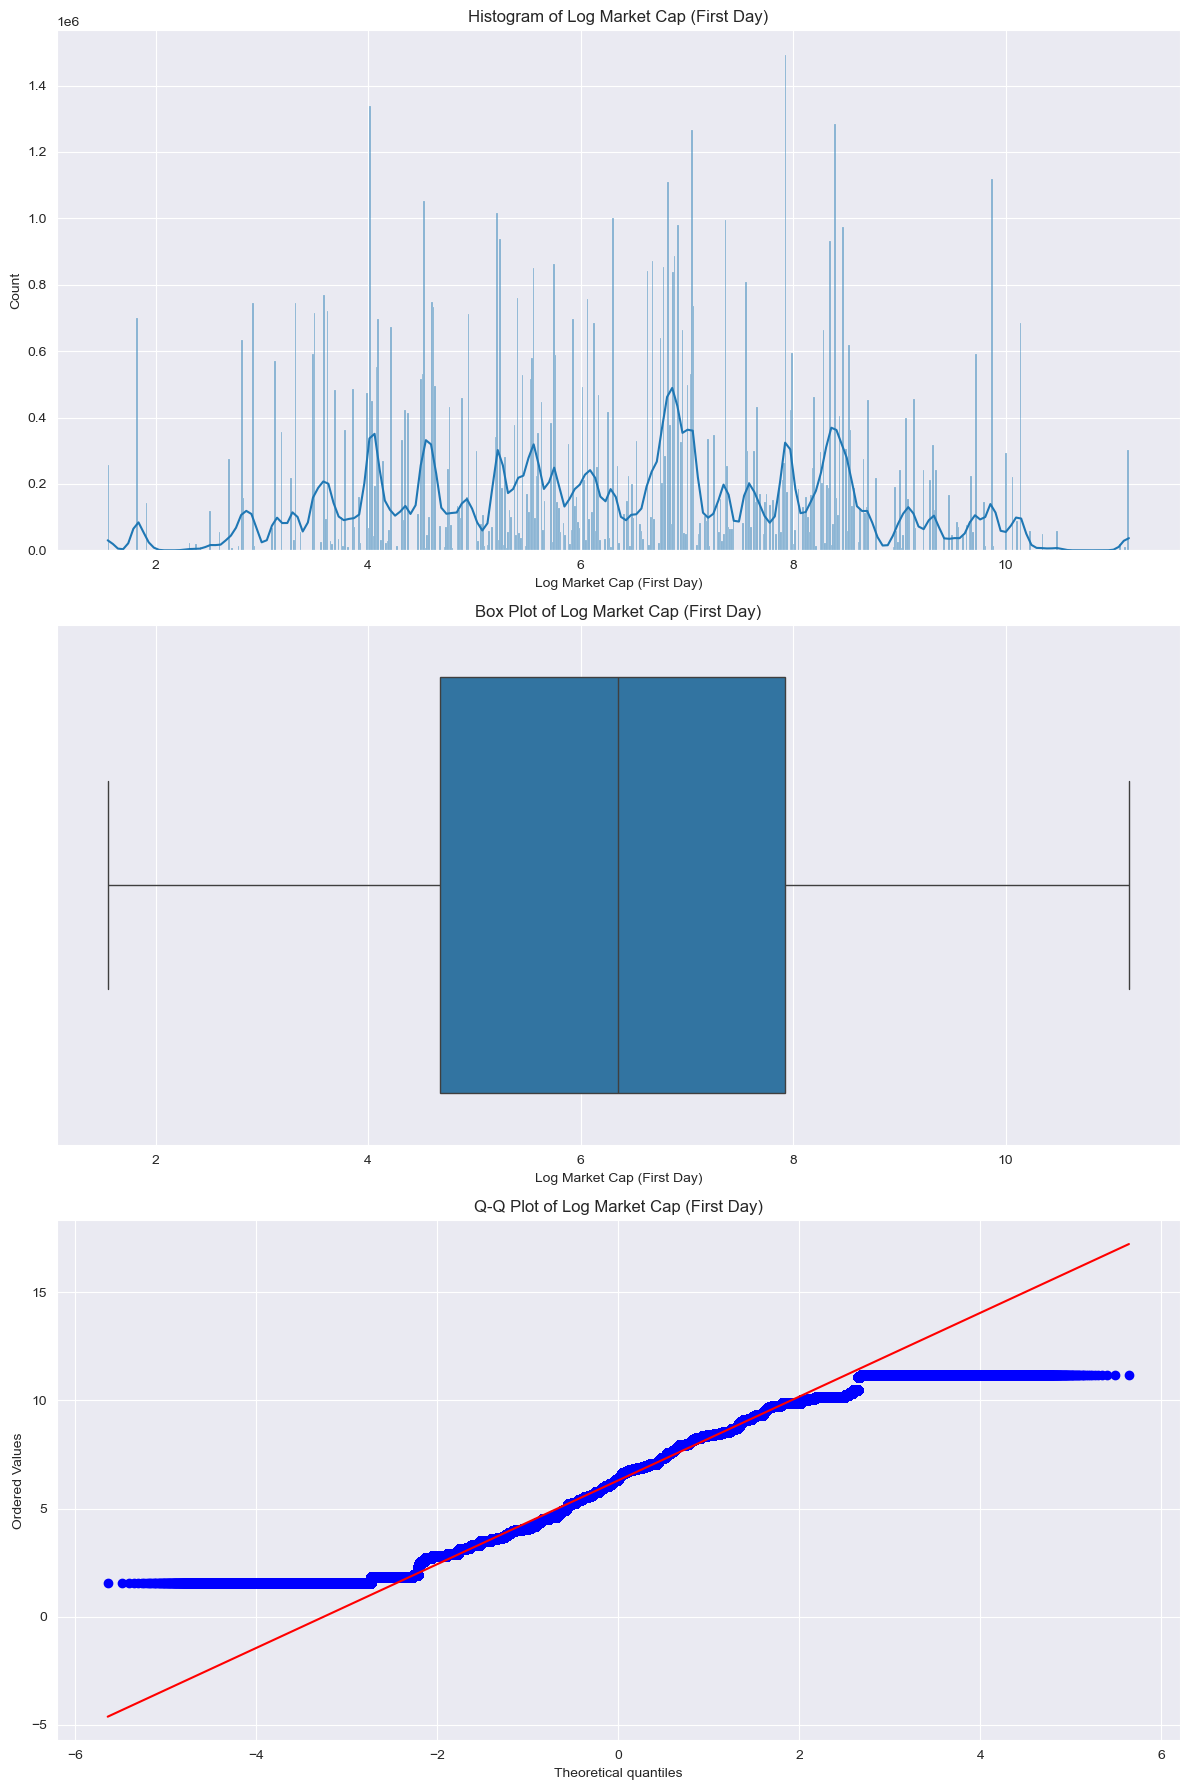


Percentage of data within 1 standard deviation: 61.35%
Percentage of data within 2 standard deviations: 98.00%
Percentage of data within 3 standard deviations: 100.00%

Number of negative values: 0


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set the file path
file_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File '{file_path}' not found. Please check the file path.")
    exit()

# Read the target variable
target_df = pd.read_parquet(file_path)

# Apply log transformation
target_df['log_marketcap_first_day'] = np.log1p(target_df['marketcap_first_day'])

# Descriptive statistics
desc_stats = target_df['log_marketcap_first_day'].describe()
print("Descriptive Statistics (Log-transformed):")
print(desc_stats)

# Additional statistics
skewness = target_df['log_marketcap_first_day'].skew()
kurtosis = target_df['log_marketcap_first_day'].kurtosis()
print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

# Create a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# Histogram
sns.histplot(data=target_df, x='log_marketcap_first_day', kde=True, ax=ax1)
ax1.set_title('Histogram of Log Market Cap (First Day)')
ax1.set_xlabel('Log Market Cap (First Day)')

# Box plot
sns.boxplot(x=target_df['log_marketcap_first_day'], ax=ax2)
ax2.set_title('Box Plot of Log Market Cap (First Day)')
ax2.set_xlabel('Log Market Cap (First Day)')

# Q-Q plot
stats.probplot(target_df['log_marketcap_first_day'], dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot of Log Market Cap (First Day)')

plt.tight_layout()
plt.savefig('log_marketcap_first_day_analysis.png')
plt.show()

# Calculate the percentage of data within 1, 2, and 3 standard deviations
mean = target_df['log_marketcap_first_day'].mean()
std = target_df['log_marketcap_first_day'].std()

within_1_std = ((target_df['log_marketcap_first_day'] >= mean - std) &
                (target_df['log_marketcap_first_day'] <= mean + std)).mean()
within_2_std = ((target_df['log_marketcap_first_day'] >= mean - 2*std) &
                (target_df['log_marketcap_first_day'] <= mean + 2*std)).mean()
within_3_std = ((target_df['log_marketcap_first_day'] >= mean - 3*std) &
                (target_df['log_marketcap_first_day'] <= mean + 3*std)).mean()

print(f"\nPercentage of data within 1 standard deviation: {within_1_std:.2%}")
print(f"Percentage of data within 2 standard deviations: {within_2_std:.2%}")
print(f"Percentage of data within 3 standard deviations: {within_3_std:.2%}")

# Check for negative values (there shouldn't be any after log1p transformation)
negative_count = (target_df['log_marketcap_first_day'] < 0).sum()

print(f"\nNumber of negative values: {negative_count}")

In [20]:
import pandas as pd
import numpy as np

target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'
target_df = pd.read_parquet(target_path)

print("Total rows:", len(target_df))
print("Rows with non-NaN values:", target_df['marketcap_first_day'].notna().sum())
print("First row with NaN:", target_df['marketcap_first_day'].isna().idxmax())

Total rows: 81984666
Rows with non-NaN values: 81984666
First row with NaN: 0


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pyarrow.parquet as pq

class IncrementalPipeline:
    def __init__(self):
        self.numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        self.categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        self.preprocessor = None
        self.model = SGDRegressor(random_state=42)

    def partial_fit(self, X, y):
        if self.preprocessor is None:
            numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
            categorical_features = X.select_dtypes(include=['object', 'category']).columns

            self.preprocessor = ColumnTransformer(
                transformers=[
                    ('num', self.numeric_transformer, numeric_features),
                    ('cat', self.categorical_transformer, categorical_features)
                ])

            X_transformed = self.preprocessor.fit_transform(X)
        else:
            X_transformed = self.preprocessor.transform(X)

        self.model.partial_fit(X_transformed, y)

    def predict(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict(X_transformed)

# Paths to your data files
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Function to process data in chunks
def process_data_in_chunks(features_path, target_path, chunk_size=10000):
    features_table = pq.read_table(features_path)
    target_table = pq.read_table(target_path)

    num_rows = len(features_table)
    for i in range(0, num_rows, chunk_size):
        features_chunk = features_table.slice(i, chunk_size).to_pandas()
        target_chunk = target_table.slice(i, chunk_size).to_pandas()

        # Prepare the target variable
        y = np.log1p(target_chunk['marketcap_first_day'])

        yield features_chunk, y

# Initialize the incremental pipeline
pipeline = IncrementalPipeline()

# Process data in chunks
for i, (features_chunk, y_chunk) in enumerate(process_data_in_chunks(features_path, target_path)):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features_chunk, y_chunk, test_size=0.2, random_state=42)

    # Fit the model incrementally
    pipeline.partial_fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Chunk {i+1} - MSE: {mse}, R2: {r2}")

print("\nTraining completed. The model is now trained on the entire dataset.")

# Feature Importance
feature_importance = np.abs(pipeline.model.coef_)
feature_names = pipeline.preprocessor.get_feature_names_out()

# Create a dataframe of feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False).head(10)

print("\nTop 10 Important Features:")
print(importance_df)

Chunk 1 - MSE: 0.0002918027672524411, R2: -3.6990395305581525e+26
Chunk 2 - MSE: 4.0716437533993685e+25, R2: -5.16142164791223e+55
Chunk 3 - MSE: 2.6926789409596537e+27, R2: -3.413376075729418e+57
Chunk 4 - MSE: 3.7730857193264725e+27, R2: -4.7829543768167635e+57
Chunk 5 - MSE: 1.463271070291759e+30, R2: -1.854916450551952e+60
Chunk 6 - MSE: 1.6353791507886046e+28, R2: -2.0730893620979067e+58
Chunk 7 - MSE: 2.1217628267205967e+21, R2: -2.689653920834309e+51
Chunk 8 - MSE: 2.2390000779972358e+26, R2: -2.8382697927842484e+56
Chunk 9 - MSE: 6.499810619554553e+26, R2: -8.239488833248149e+56
Chunk 10 - MSE: 1.7633154430897184e+29, R2: -2.235267879824388e+59
Chunk 11 - MSE: 1.2678129723075414e+30, R2: -1.6071438753227904e+60
Chunk 12 - MSE: 1.150148504775852e+38, R2: -9.367073749786046e+38
Chunk 13 - MSE: 6.2773108886857254e+35, R2: 0.0
Chunk 14 - MSE: 1.561378182146713e+37, R2: 0.0
Chunk 15 - MSE: 1.0279453302687558e+38, R2: 0.0
Chunk 16 - MSE: 1.5465770478858792e+39, R2: -2.231675156460301

In [49]:
import dask.dataframe as dd
import pandas as pd

# Load the data using Dask
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
features_ddf = dd.read_parquet(features_path)

# Print basic information about the datasets
print("Features dataset info:")
print(features_ddf.info())

# Check data types of columns
print("\nData types of features columns:")
print(features_ddf.dtypes)

Features dataset info:
<class 'dask_expr.DataFrame'>
Columns: 61 entries, investmentsc to netinc_squared
dtypes: float64(61)None

Data types of features columns:
investmentsc           float64
investments            float64
ncfo                   float64
revenue                float64
fcf                    float64
                        ...   
investments_squared    float64
ncfo_squared           float64
revenue_squared        float64
fcf_squared            float64
netinc_squared         float64
Length: 61, dtype: object


In [58]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

# Function to read the entire Parquet file
def read_full_parquet(file_path):
    return pq.read_table(file_path).to_pandas()

# Full file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read the full target variable data
full_y_df = read_full_parquet(target_path)

print("Full target variable data shape:", full_y_df.shape)
print("\nFull target variable statistics:")
print(full_y_df['marketcap_first_day'].describe())

print("\nUnique values in full target variable:")
print(full_y_df['marketcap_first_day'].nunique())

print("\nFirst 10 values of full target variable:")
print(full_y_df['marketcap_first_day'].head(10))

print("\nLast 10 values of full target variable:")
print(full_y_df['marketcap_first_day'].tail(10))

# Check for any extreme values
print("\nMin value:", full_y_df['marketcap_first_day'].min())
print("Max value:", full_y_df['marketcap_first_day'].max())

# Check data type
print("\nData type of target variable:", full_y_df['marketcap_first_day'].dtype)

# If the data looks fine, let's check the sampling process
sample_size = 100000
sampled_y_df = full_y_df.sample(n=min(sample_size, len(full_y_df)), random_state=42)

print("\nSampled target variable statistics:")
print(sampled_y_df['marketcap_first_day'].describe())

print("\nUnique values in sampled target variable:")
print(sampled_y_df['marketcap_first_day'].nunique())

# Check if all values are exactly 255.0 in the sample
print("\nAll values equal to 255.0 in sample:", (sampled_y_df['marketcap_first_day'] == 255.0).all())

# If all values are still 255.0, print the entire sampled dataset
if (sampled_y_df['marketcap_first_day'] == 255.0).all():
    print("\nAll sampled values:")
    print(sampled_y_df['marketcap_first_day'].values)

Full target variable data shape: (81984666, 1)

Full target variable statistics:
count    8.198467e+07
mean     2.709088e+03
std      6.358931e+03
min      3.700000e+00
25%      1.066000e+02
50%      5.734000e+02
75%      2.755200e+03
max      7.041230e+04
Name: marketcap_first_day, dtype: float64

Unique values in full target variable:
529

First 10 values of full target variable:
0    255.0
1    255.0
2    255.0
3    255.0
4    255.0
5    255.0
6    255.0
7    255.0
8    255.0
9    255.0
Name: marketcap_first_day, dtype: float64

Last 10 values of full target variable:
81984656    2050.2
81984657    2050.2
81984658    2050.2
81984659    2050.2
81984660    2050.2
81984661    2050.2
81984662    2050.2
81984663    2050.2
81984664    2050.2
81984665    2050.2
Name: marketcap_first_day, dtype: float64

Min value: 3.7
Max value: 70412.3

Data type of target variable: float64

Sampled target variable statistics:
count    100000.000000
mean       2709.299455
std        6377.665454
min       

In [59]:
y_df = pd.read_parquet(target_path).sample(n=sample_size, random_state=42)
print("Target variable statistics:")
print(y_df['marketcap_first_day'].describe())
print("\nUnique values in target variable:")
print(y_df['marketcap_first_day'].nunique())

Target variable statistics:
count    100000.000000
mean       2709.299455
std        6377.665454
min           3.700000
25%         114.000000
50%         623.900000
75%        2755.200000
max       70412.300000
Name: marketcap_first_day, dtype: float64

Unique values in target variable:
528


Features statistics:
        investmentsc    investments           ncfo        revenue  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       35.138011     114.280812      15.070138      86.362774   
std       119.480456     464.045876      53.432752     260.336071   
min        -1.354057      -3.185049     -60.633301      -0.706091   
25%        -1.354057      -3.185049      -0.134902       0.751124   
50%        -1.354057      -3.182251       0.451037      12.058993   
75%         4.177275      23.657178       6.425576      49.142539   
max       734.944502    3303.697167     358.550804    1811.427031   

                 fcf         netinc  asset_utilization         ebitda  \
count  100000.000000  100000.000000      100000.000000  100000.000000   
mean        6.015130      -3.688349           0.905661      17.362547   
std        53.135569      48.408149           1.765948      82.102320   
min      -251.284423    -246.524774          -0.815770    -132.82

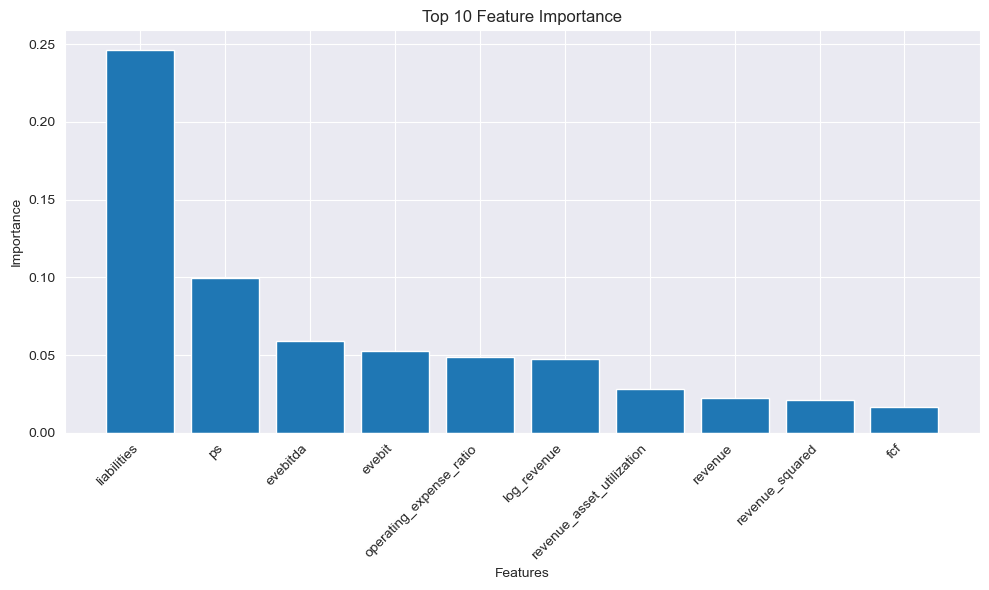

In [62]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to read a sample of the data in chunks
def read_parquet_sample(file_path, sample_size=100000, chunk_size=10000):
    total_rows = pq.read_metadata(file_path).num_rows
    sample_indices = np.random.choice(total_rows, size=sample_size, replace=False)
    sample_indices.sort()

    chunks = []
    chunk_start = 0
    for chunk in pq.ParquetFile(file_path).iter_batches(batch_size=chunk_size):
        chunk_end = chunk_start + len(chunk)
        chunk_indices = sample_indices[(sample_indices >= chunk_start) & (sample_indices < chunk_end)] - chunk_start
        if len(chunk_indices) > 0:
            chunks.append(chunk.to_pandas().iloc[chunk_indices])
        chunk_start = chunk_end
        if chunk_start > sample_indices[-1]:
            break
    return pd.concat(chunks, ignore_index=True)

# Full file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read a sample of the dataset
sample_size = 100000
X = read_parquet_sample(features_path, sample_size)
y_df = read_parquet_sample(target_path, sample_size)

# Print diagnostics for features
print("Features statistics:")
print(X.describe())
print("\nFeatures data types:")
print(X.dtypes)

# Print diagnostics for target variable
print("\nTarget variable statistics:")
print(y_df['marketcap_first_day'].describe())
print("\nUnique values in target variable:")
print(y_df['marketcap_first_day'].nunique())

# Apply log transformation to the target variable
y = np.log(y_df['marketcap_first_day'])

print(f"\nSample size: {len(X)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print diagnostics for train/test split
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("y_train unique values:", y_train.nunique())
print("y_test unique values:", y_test.nunique())

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error (on log scale): {mse}")
print(f"R-squared Score (on log scale): {r2}")

# Calculate RMSE on the original scale
rmse_original = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print(f"Root Mean Squared Error (on original scale): {rmse_original}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# Optional: Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Sample size: 100000

Random Forest Performance:
Mean Squared Error (on log scale): 1.1782572704869587
R-squared Score (on log scale): 0.692347770378767
Root Mean Squared Error (on original scale): 4003.361972567009

XGBoost Performance:
Mean Squared Error (on log scale): 1.3632267323381615
R-squared Score (on log scale): 0.6440507907837729
Root Mean Squared Error (on original scale): 4709.054697785831

Linear Regression Performance:
Mean Squared Error (on log scale): 2.902726311512065
R-squared Score (on log scale): 0.2420753564730168
Root Mean Squared Error (on original scale): 5923.63423770168

Support Vector Regression Performance:
Mean Squared Error (on log scale): 2.5168503685448247
R-squared Score (on log scale): 0.34283059659303206
Root Mean Squared Error (on original scale): 5073.566869208414

K-Nearest Neighbors Performance:
Mean Squared Error (on log scale): 1.5894426866681988
R-squared Score (on log scale): 0.5849840279733318
Root Mean Squared Error (on original scale): 4456

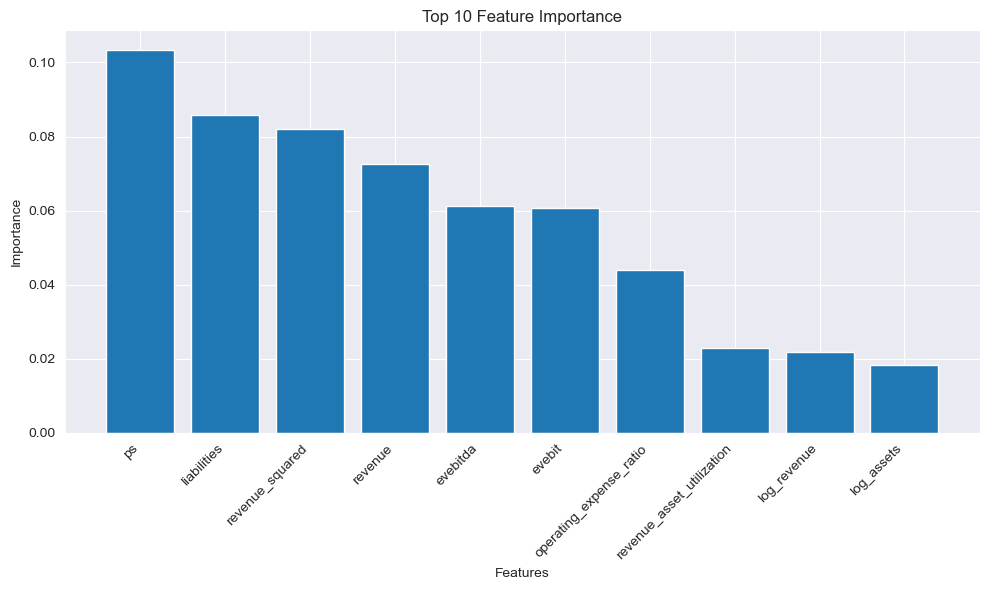

In [63]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Function to read a sample of the data in chunks (same as before)
def read_parquet_sample(file_path, sample_size=100000, chunk_size=10000):
    total_rows = pq.read_metadata(file_path).num_rows
    sample_indices = np.random.choice(total_rows, size=sample_size, replace=False)
    sample_indices.sort()

    chunks = []
    chunk_start = 0
    for chunk in pq.ParquetFile(file_path).iter_batches(batch_size=chunk_size):
        chunk_end = chunk_start + len(chunk)
        chunk_indices = sample_indices[(sample_indices >= chunk_start) & (sample_indices < chunk_end)] - chunk_start
        if len(chunk_indices) > 0:
            chunks.append(chunk.to_pandas().iloc[chunk_indices])
        chunk_start = chunk_end
        if chunk_start > sample_indices[-1]:
            break
    return pd.concat(chunks, ignore_index=True)

# Full file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read a sample of the dataset
sample_size = 100000
X = read_parquet_sample(features_path, sample_size)
y_df = read_parquet_sample(target_path, sample_size)

# Apply log transformation to the target variable
y = np.log(y_df['marketcap_first_day'])

print(f"Sample size: {len(X)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse_original = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
    print(f"\n{model_name} Performance:")
    print(f"Mean Squared Error (on log scale): {mse}")
    print(f"R-squared Score (on log scale): {r2}")
    print(f"Root Mean Squared Error (on original scale): {rmse_original}")
    return mse, r2, rmse_original

# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
rf_mse, rf_r2, rf_rmse = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# 2. Gradient Boosting (XGBoost)
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_mse, xgb_r2, xgb_rmse = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

# 3. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_mse, lr_r2, lr_rmse = evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression")

# 4. Support Vector Regression
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
svr_mse, svr_r2, svr_rmse = evaluate_model(svr_model, X_test_scaled, y_test, "Support Vector Regression")

# 5. K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_mse, knn_r2, knn_rmse = evaluate_model(knn_model, X_test_scaled, y_test, "K-Nearest Neighbors")

# Compare models
models = ["Random Forest", "XGBoost", "Linear Regression", "SVR", "KNN"]
mse_scores = [rf_mse, xgb_mse, lr_mse, svr_mse, knn_mse]
r2_scores = [rf_r2, xgb_r2, lr_r2, svr_r2, knn_r2]
rmse_scores = [rf_rmse, xgb_rmse, lr_rmse, svr_rmse, knn_rmse]

comparison_df = pd.DataFrame({
    "Model": models,
    "MSE (log scale)": mse_scores,
    "R-squared (log scale)": r2_scores,
    "RMSE (original scale)": rmse_scores
})

print("\nModel Comparison:")
print(comparison_df.sort_values("R-squared (log scale)", ascending=False))

# Feature Importance for the best model (assuming it's Random Forest or XGBoost)
best_model = rf_model if rf_r2 > xgb_r2 else xgb_model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm
import os

# File paths
csv_file = r'C:\Users\Katarina\OneDrive\Desktop\updated_cleaned_engineered_features_dataset_v2.csv'
parquet_file = r'C:\Users\Katarina\OneDrive\Desktop\preprocessed_features.parquet'
output_file = r'C:\Users\Katarina\OneDrive\Desktop\updated_preprocessed_features.parquet'

def process_files_in_chunks(parquet_file, csv_file, output_file, chunk_size=1000000):
    parquet_file = pq.ParquetFile(parquet_file)
    total_rows = parquet_file.metadata.num_rows
    num_chunks = (total_rows + chunk_size - 1) // chunk_size

    writer = None
    csv_reader = pd.read_csv(csv_file, usecols=['pe_first_day'], chunksize=chunk_size)

    with tqdm(total=num_chunks, desc="Processing chunks") as pbar:
        for i, (batch, csv_chunk) in enumerate(zip(parquet_file.iter_batches(batch_size=chunk_size), csv_reader)):
            # Convert Arrow table to pandas DataFrame
            df_chunk = batch.to_pandas()

            # Remove 'pe' column if it exists
            if 'pe' in df_chunk.columns:
                df_chunk = df_chunk.drop('pe', axis=1)

            # Add 'pe_first_day' to the chunk
            df_chunk['pe_first_day'] = csv_chunk['pe_first_day'].values

            # Convert back to Arrow table
            table = pa.Table.from_pandas(df_chunk)

            # If it's the first chunk, create the writer with the schema
            if writer is None:
                writer = pq.ParquetWriter(output_file, schema=table.schema)

            # Write the chunk
            writer.write_table(table)

            pbar.update(1)

    # Close the writer
    if writer:
        writer.close()

# Process the files
print("Processing files in chunks...")
process_files_in_chunks(parquet_file, csv_file, output_file)

print(f"Updated Parquet file has been created: {output_file}")
print("Added 'pe_first_day' and removed 'pe' column.")

# Read a small sample to verify the columns
sample = pd.read_parquet(output_file, columns=None, engine='pyarrow')
print(f"New column list: {sample.columns.tolist()}")

Processing files in chunks...


Processing chunks: 100%|██████████| 82/82 [04:43<00:00,  3.46s/it]


Updated Parquet file has been created: C:\Users\Katarina\OneDrive\Desktop\updated_preprocessed_features.parquet
Added 'pe_first_day' and removed 'pe' column.
New column list: ['investmentsc', 'investments', 'ncfo', 'revenue', 'fcf', 'netinc', 'asset_utilization', 'ebitda', 'log_revenue', 'fcfps', 'fcf_to_assets', 'investmentsnc', 'log_assets', 'asset_turnover', 'ps', 'ncfinv', 'equity', 'roa', 'assets', 'net_profit_margin', 'fcf_to_revenue', 'evebit', 'capex_to_revenue', 'gross_margin', 'cash_conversion_cycle', 'assetsc', 'evebitda', 'cash_to_assets', 'ros', 'quick_ratio', 'dividend_yield_to_price', 'inventory_turnover', 'price_to_tangible_book', 'roic', 'operating_margin', 'cashneq', 'roe', 'liabilities', 'payout_ratio', 'ncfbus', 'ncfx', 'operating_expense_ratio', 'gross_profit_to_assets', 'ncff', 'earnings_yield', 'pb_missing', 'pe_missing', 'marketcap_missing', 'interest_coverage', 'capex', 'debt_to_equity', 'current_ratio', 'pb', 'investments_ncfo', 'revenue_asset_utilization', 'i

Sample size: 25000000
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.998181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15021
[LightGBM] [Info] Number of data points in the train set: 20000000, number of used features: 62
[LightGBM] [Info] Start training from score 6.292408

Random Forest Statistics:
R-squared: 0.8946
MSE: 0.4059
RMSE (original scale): 3423.8690
Residuals Skewness: 0.2887
Residuals Kurtosis: 13.1899

Top 15 Feature Importances for Random Forest:
                    feature  importance
18                   assets    0.083306
8               log_revenue    0.082760
58          revenue_squared    0.077697
3                   revenue    0.075198
37              liabilities    0.065881
12               log_assets    0.064566
14                       ps    0.057526
35                  cashneq    0.052697
25           

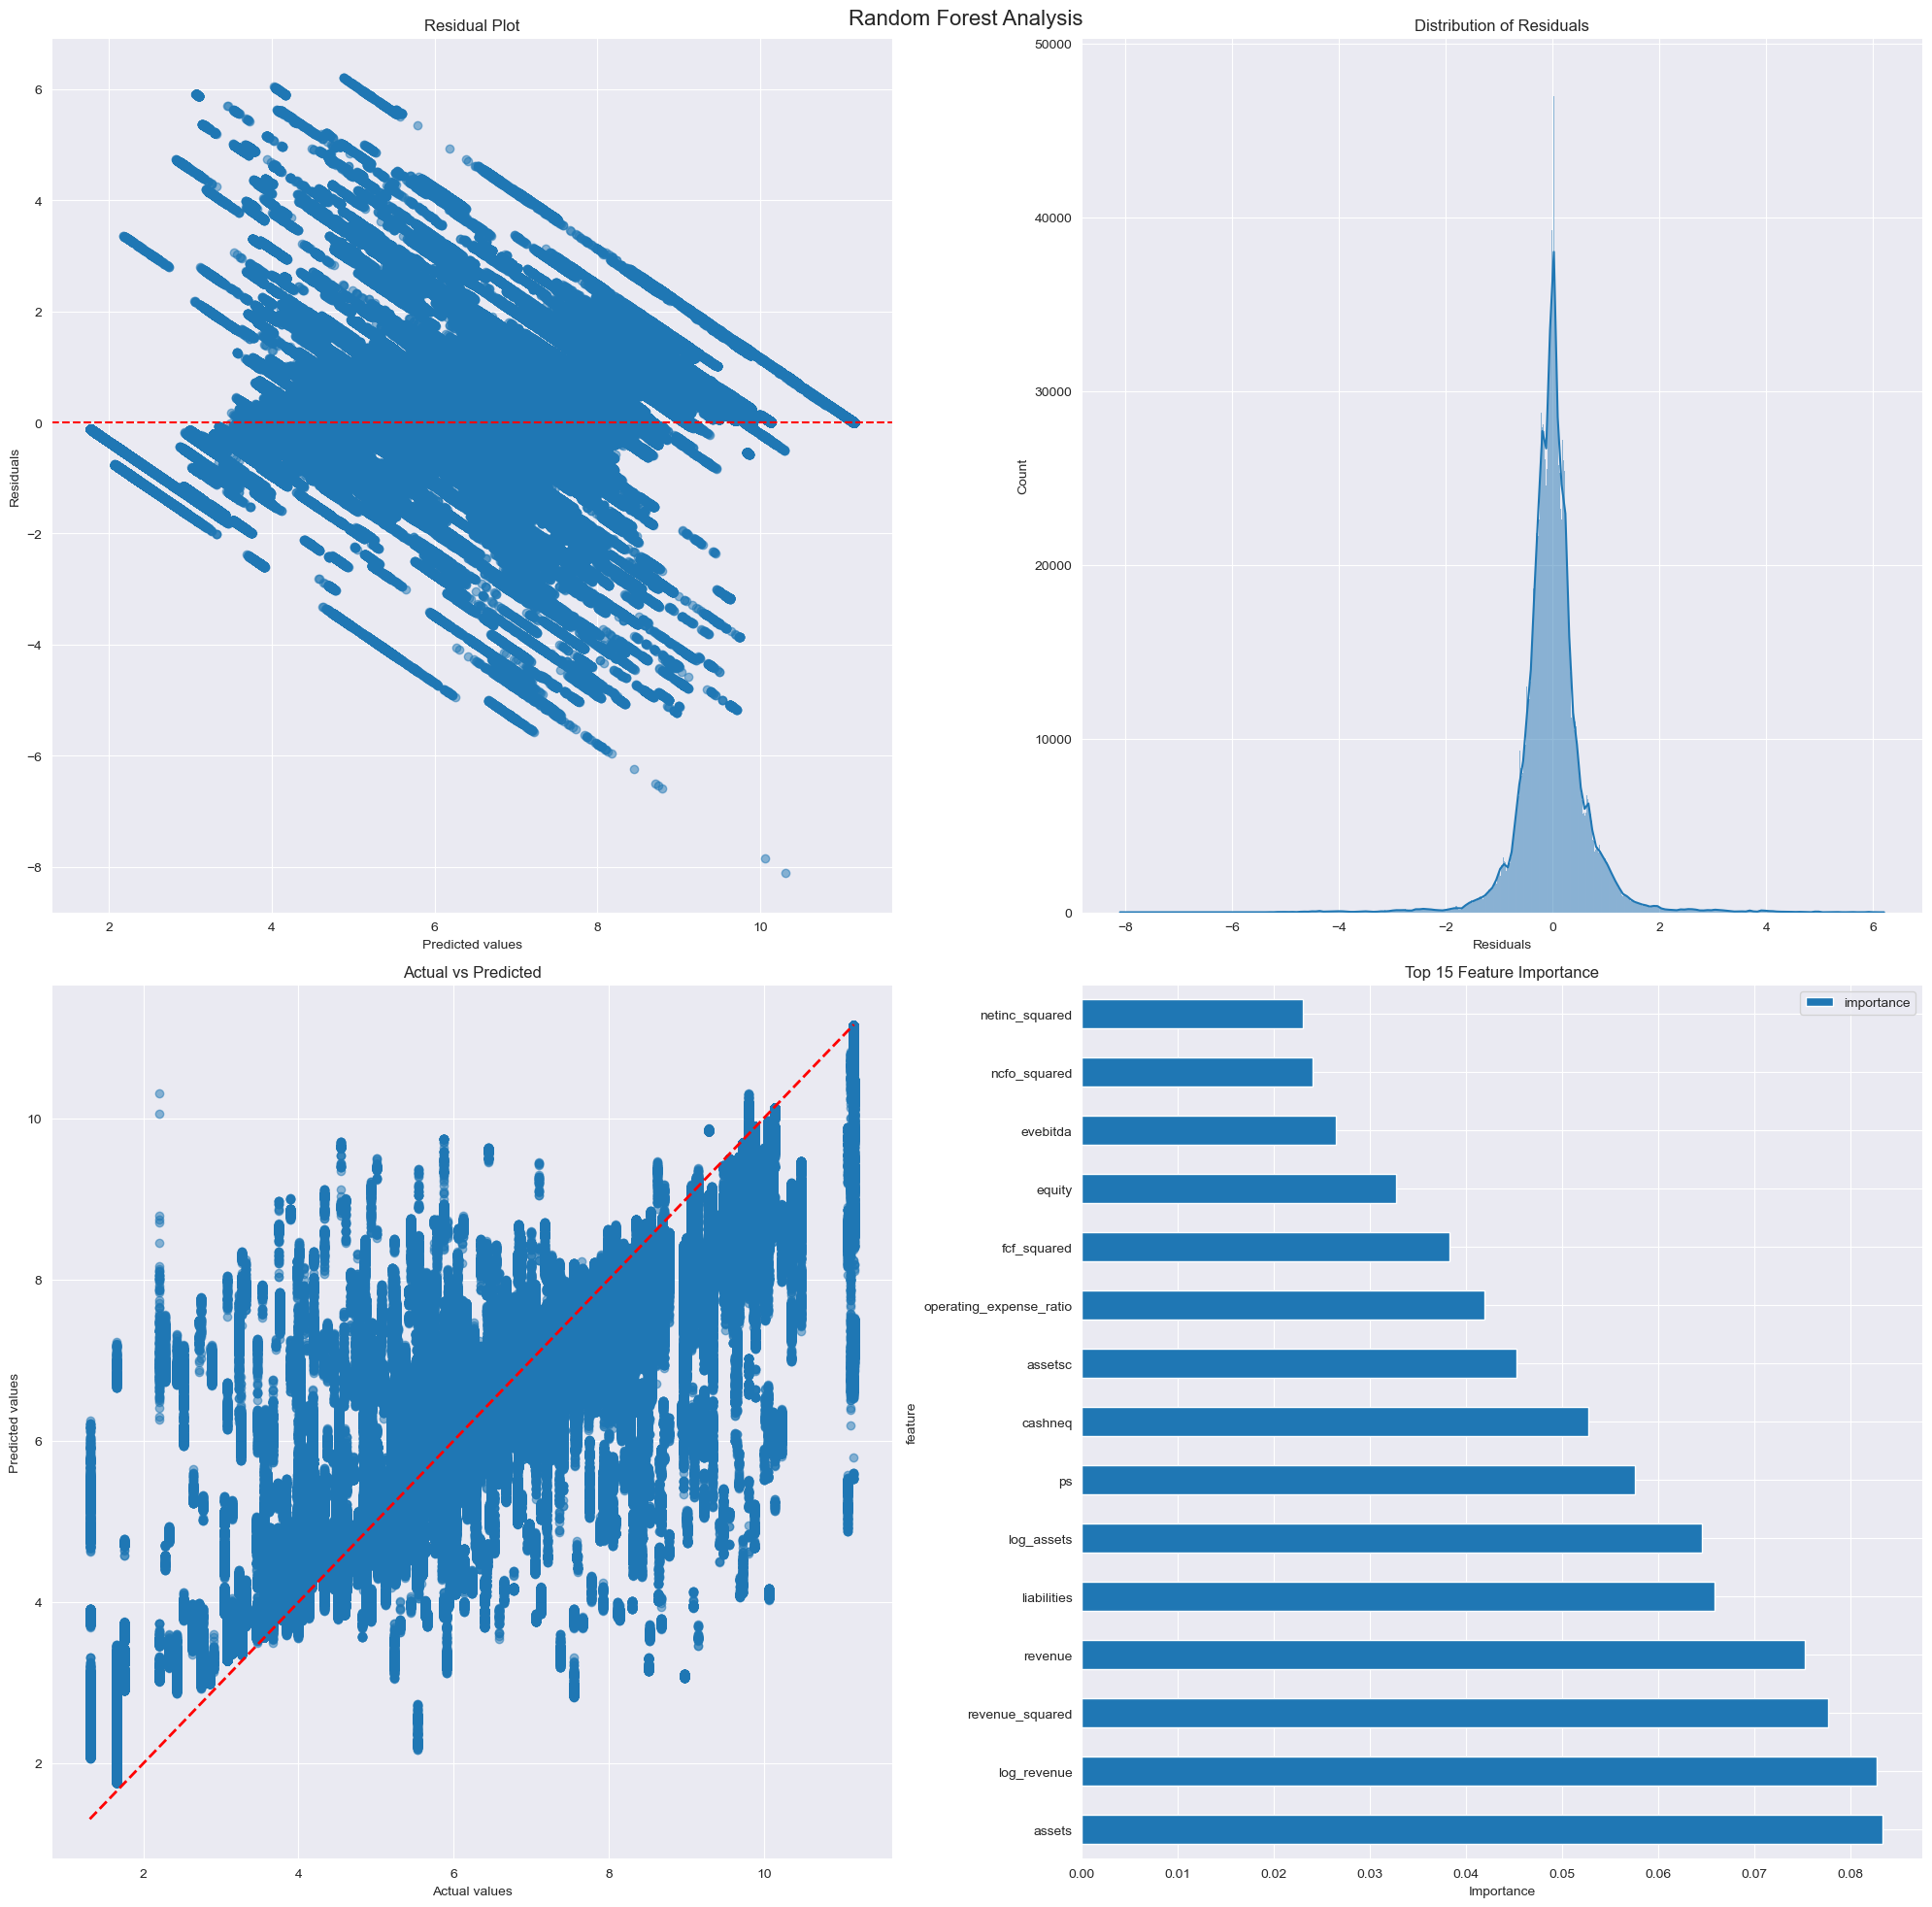

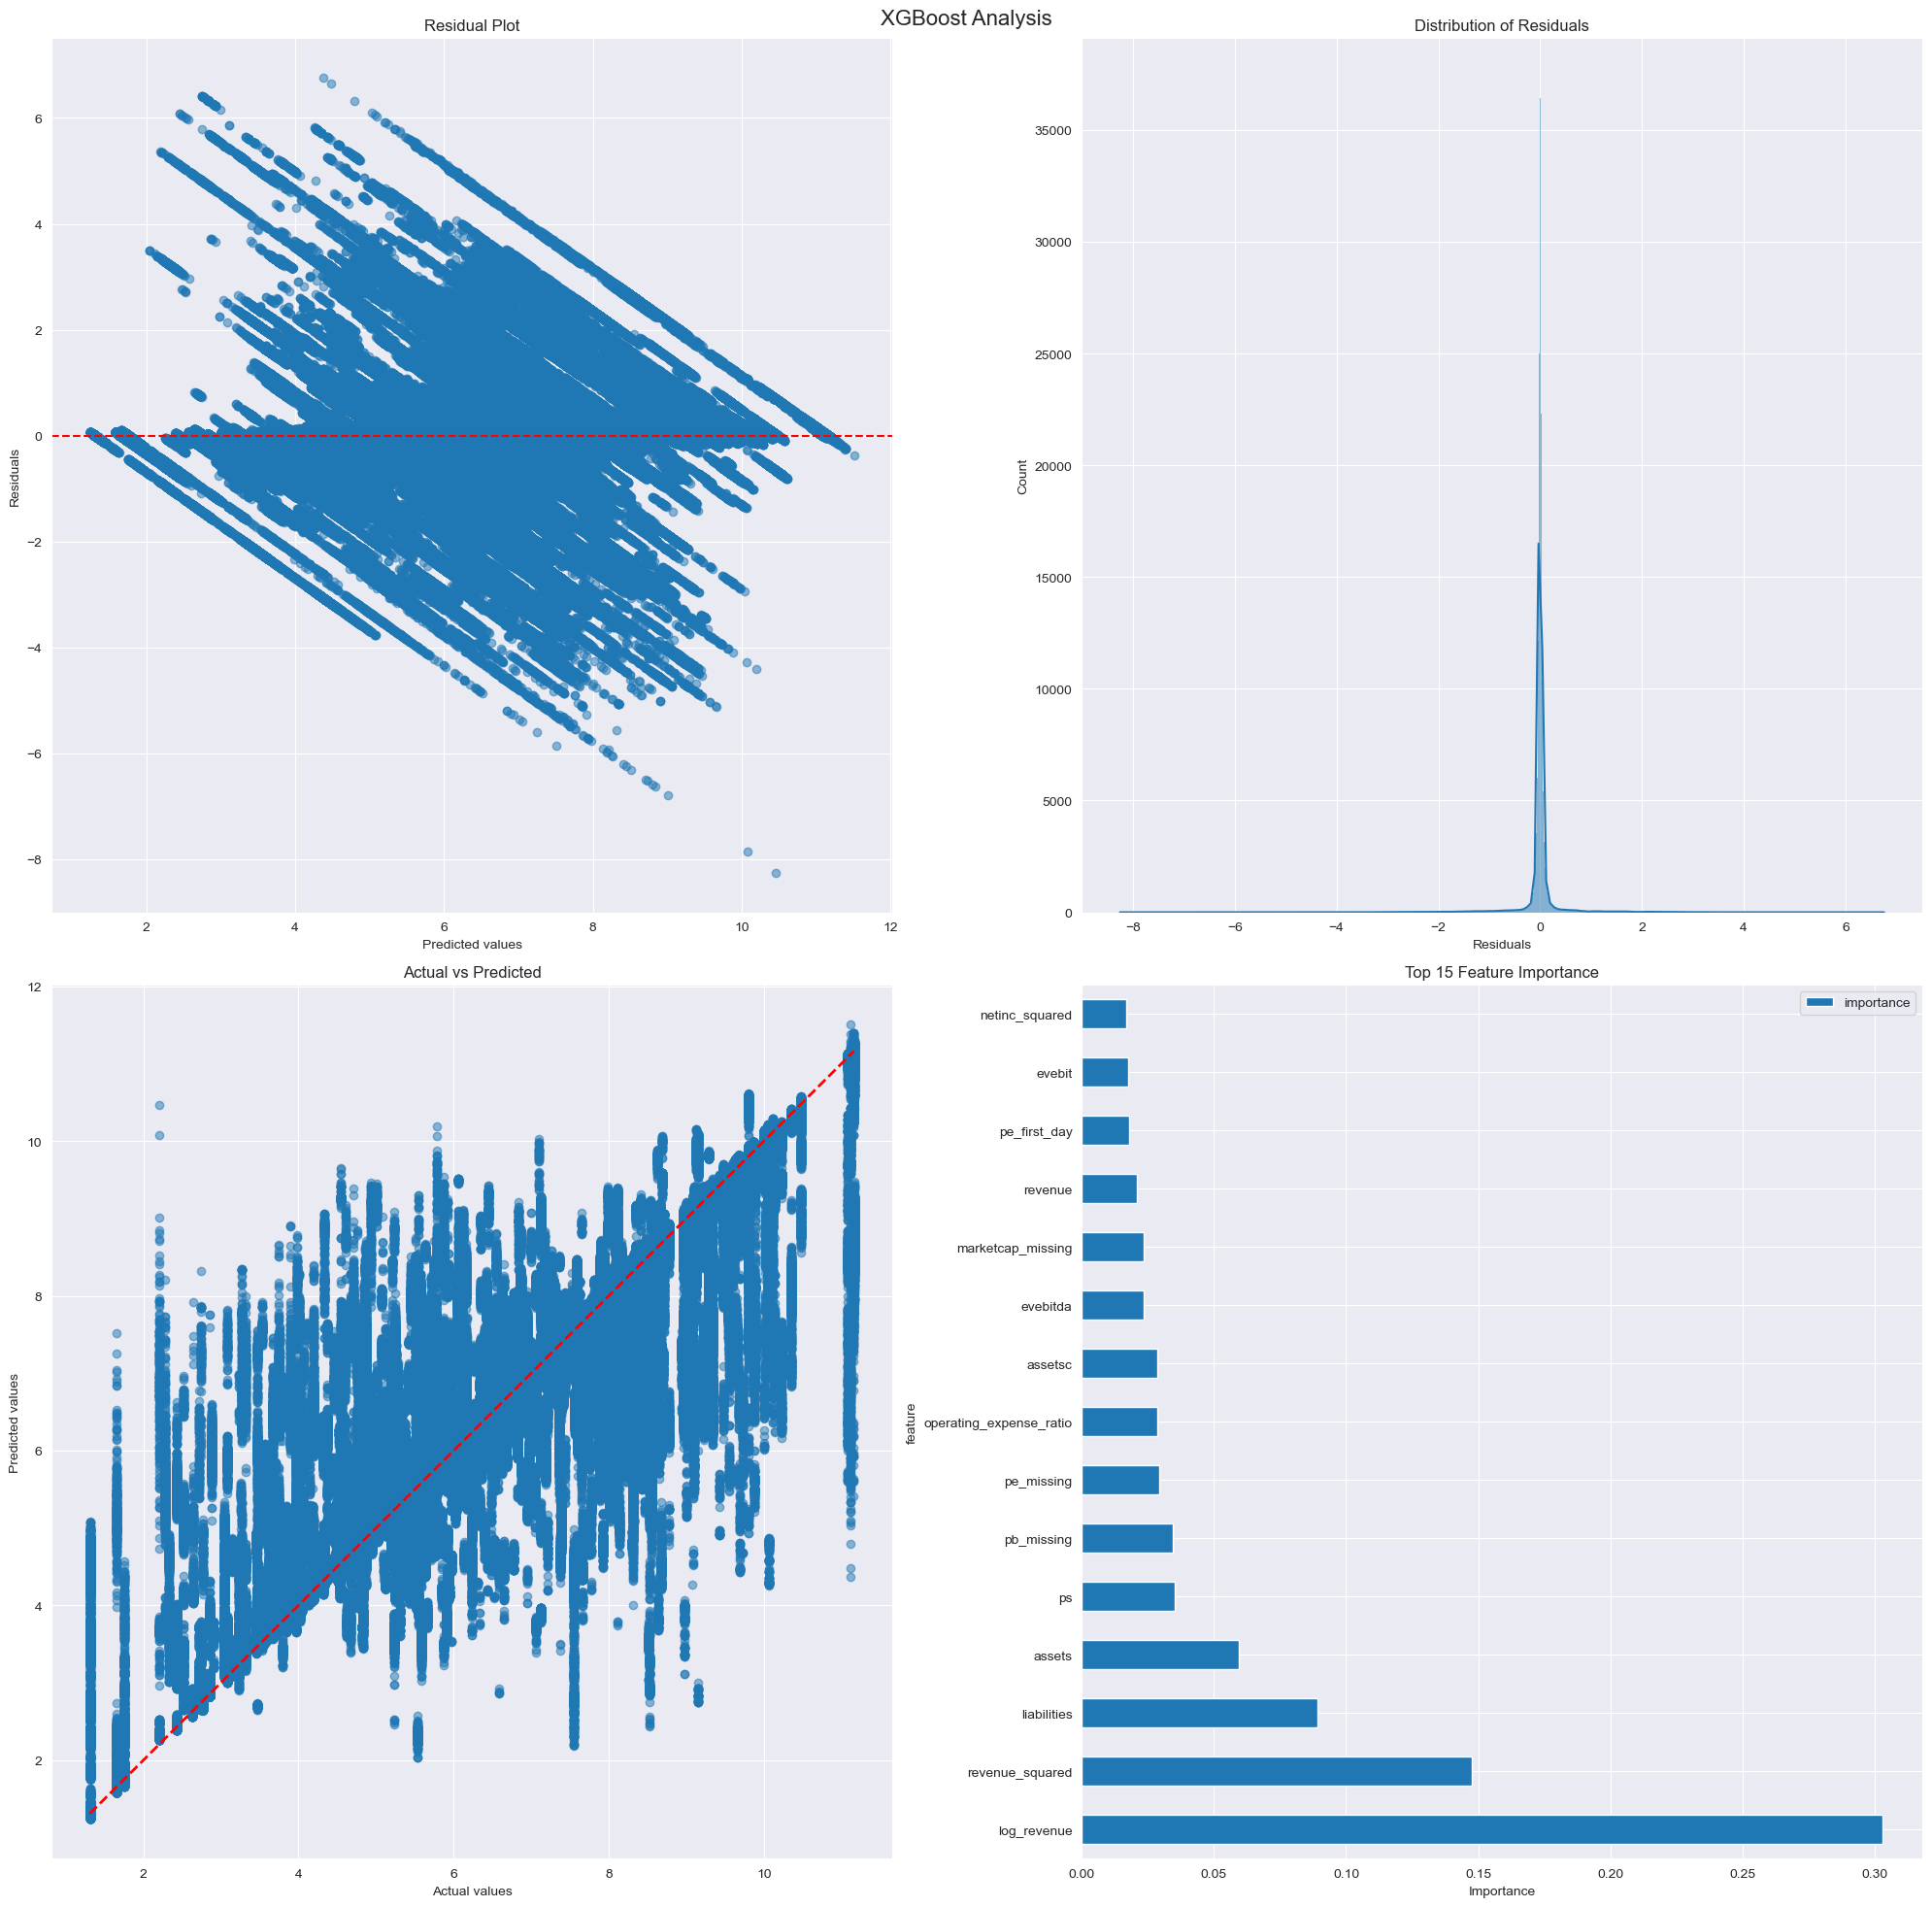

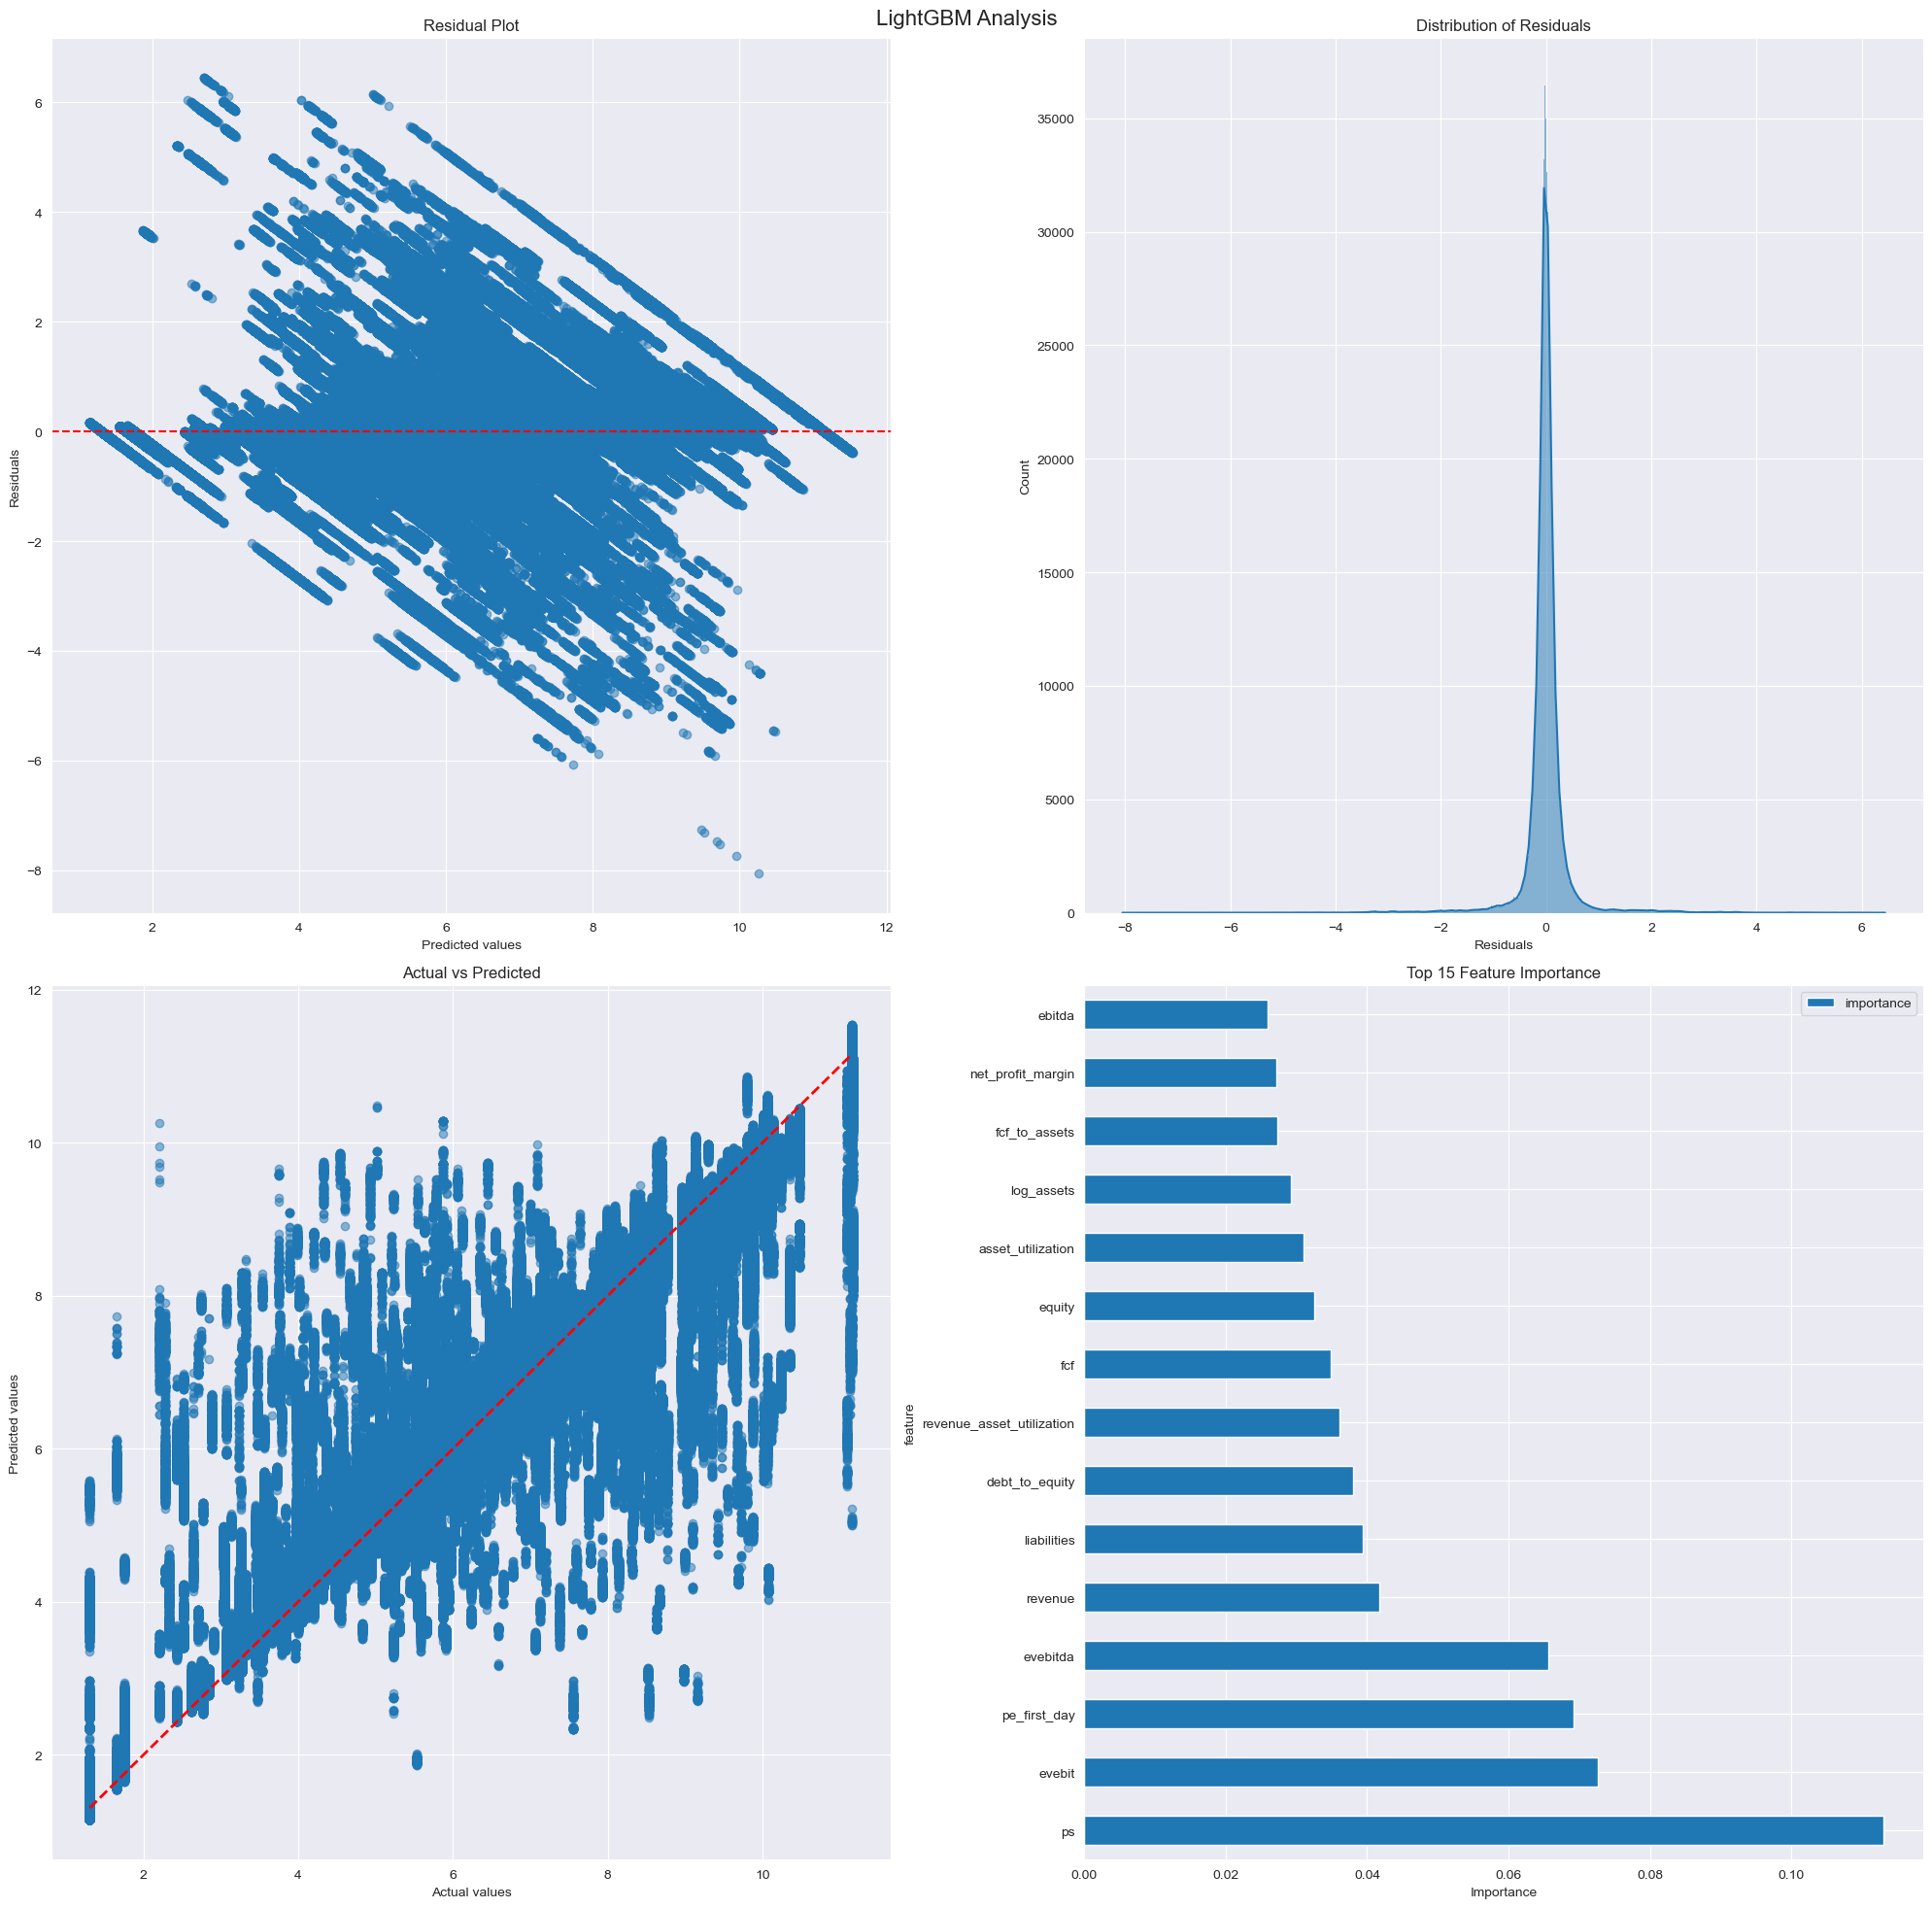

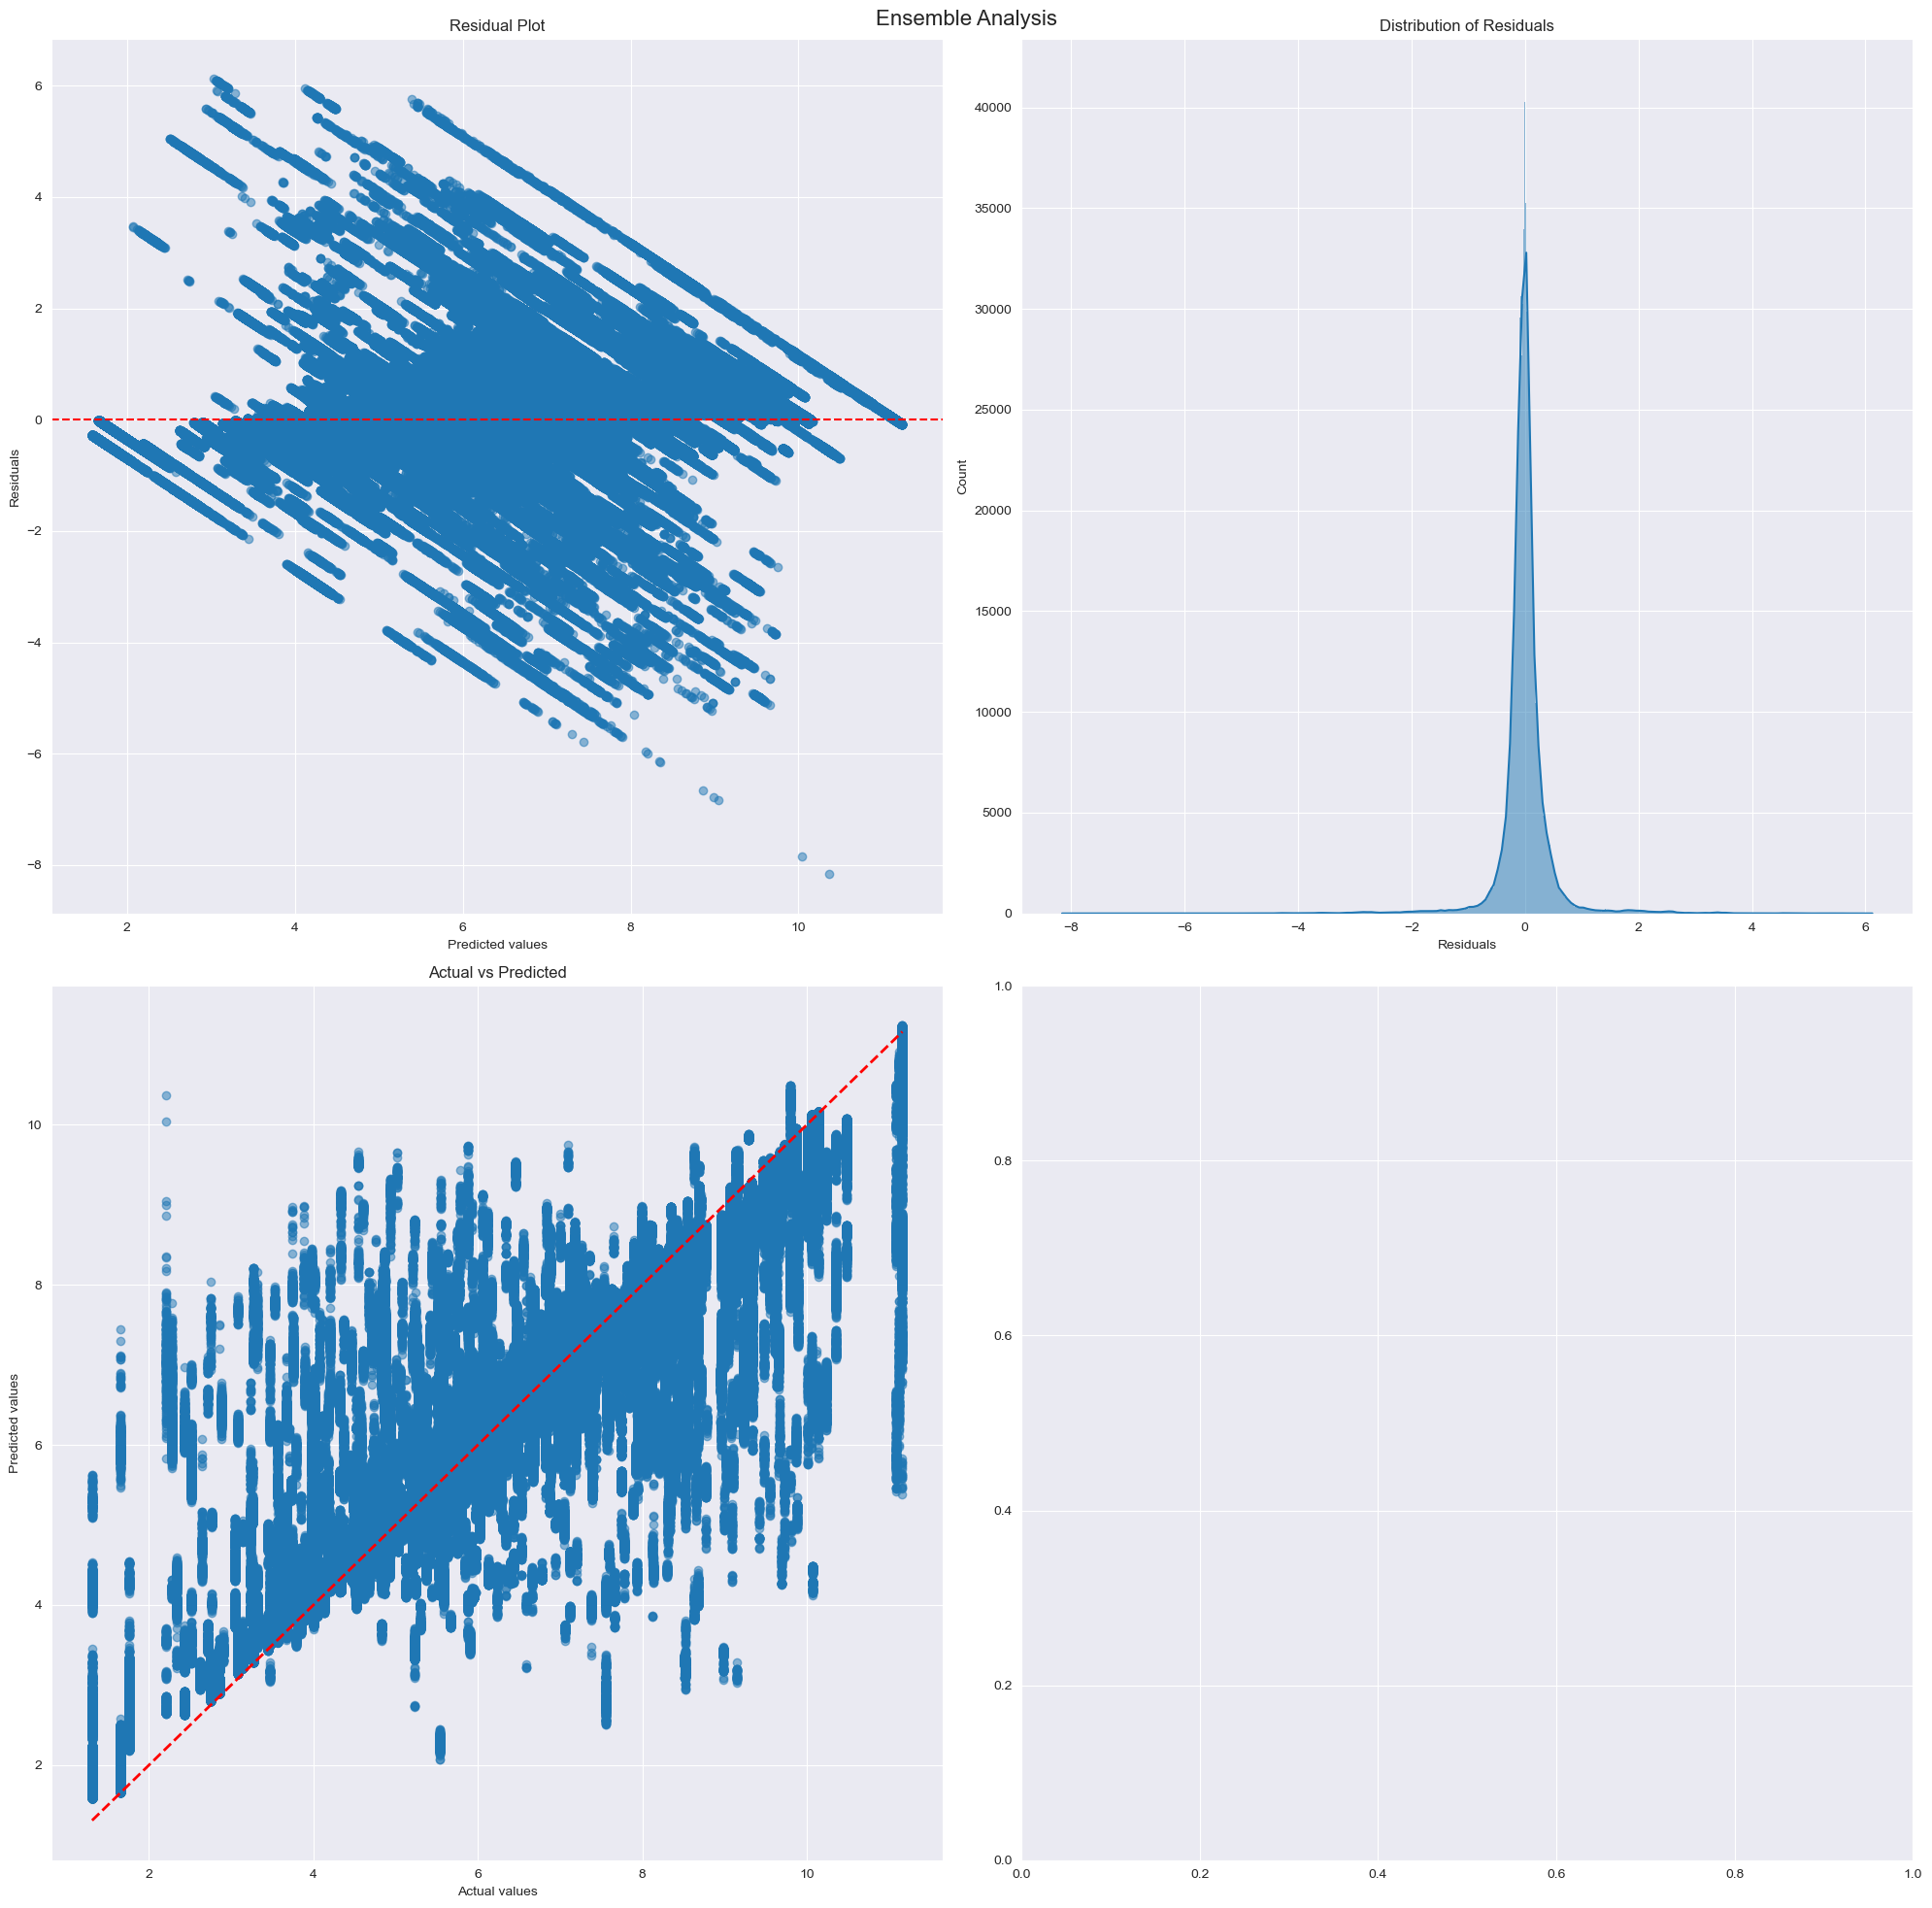


Visualization plots have been saved for all models.

Best model based on R-squared: XGBoost


In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis


def read_parquet_sample(file_path, sample_size=25000000, chunk_size=100000):
    total_rows = pq.read_metadata(file_path).num_rows
    sample_indices = np.random.choice(total_rows, size=sample_size, replace=False)
    sample_indices.sort()

    chunks = []
    chunk_start = 0
    for chunk in pq.ParquetFile(file_path).iter_batches(batch_size=chunk_size):
        chunk_end = chunk_start + len(chunk)
        chunk_indices = sample_indices[(sample_indices >= chunk_start) & (sample_indices < chunk_end)] - chunk_start
        if len(chunk_indices) > 0:
            chunks.append(chunk.to_pandas().iloc[chunk_indices])
        chunk_start = chunk_end
        if chunk_start > sample_indices[-1]:
            break
    return pd.concat(chunks, ignore_index=True)


# Full file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\updated_preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read a sample of the dataset
sample_size = 25000000
X = read_parquet_sample(features_path, sample_size)
y_df = read_parquet_sample(target_path, sample_size)

# Apply log transformation to the target variable
y = np.log(y_df['marketcap_first_day'])

print(f"Sample size: {len(X)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train base models with regularization
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
                                 max_features='sqrt', n_jobs=-1, random_state=42)
xgb_model = xgb.XGBRegressor(n_estimators=733, max_depth=9, learning_rate=0.027, colsample_bytree=0.636,
                             subsample=0.777, gamma=2.472, reg_alpha=0.1, reg_lambda=1.0, random_state=42)
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31, max_depth=-1, reg_alpha=0.1,
                              reg_lambda=1.0, random_state=42)

models = [
    ("Random Forest", rf_model),
    ("XGBoost", xgb_model),
    ("LightGBM", lgb_model)
]

predictions = {}
feature_importances = {}

for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

    # Normalize feature importances
    importances = model.feature_importances_
    normalized_importances = importances / np.sum(importances)
    feature_importances[name] = pd.DataFrame({
        'feature': X.columns,
        'importance': normalized_importances
    }).sort_values('importance', ascending=False)

# Create weighted ensemble predictions
weights = [0.4, 0.4, 0.2]  # Best weights from previous analysis
ensemble_pred = weights[0] * predictions["Random Forest"] + weights[1] * predictions["XGBoost"] + weights[2] * \
                predictions["LightGBM"]
predictions["Ensemble"] = ensemble_pred

# Calculate statistics for all models
model_stats = {}
for name, pred in predictions.items():
    residuals = y_test - pred
    model_stats[name] = {
        'R-squared': r2_score(y_test, pred),
        'MSE': mean_squared_error(y_test, pred),
        'RMSE (original scale)': np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred))),
        'Residuals Skewness': skew(residuals),
        'Residuals Kurtosis': kurtosis(residuals)
    }

# Print statistics and top 15 feature importances
for name in predictions.keys():
    print(f"\n{name} Statistics:")
    for stat, value in model_stats[name].items():
        print(f"{stat}: {value:.4f}")

    if name != "Ensemble":
        print(f"\nTop 15 Feature Importances for {name}:")
        print(feature_importances[name].head(15))


# Visualization function
def plot_model_analysis(model_name, y_true, y_pred, feature_importance=None):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f"{model_name} Analysis", fontsize=16)

    # Residual plot
    residuals = y_true - y_pred
    axes[0, 0].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 0].set_xlabel("Predicted values")
    axes[0, 0].set_ylabel("Residuals")
    axes[0, 0].set_title("Residual Plot")
    axes[0, 0].axhline(y=0, color='r', linestyle='--')

    # Distribution of residuals
    sns.histplot(residuals, kde=True, ax=axes[0, 1])
    axes[0, 1].set_xlabel("Residuals")
    axes[0, 1].set_title("Distribution of Residuals")

    # Actual vs Predicted
    axes[1, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[1, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[1, 0].set_xlabel("Actual values")
    axes[1, 0].set_ylabel("Predicted values")
    axes[1, 0].set_title("Actual vs Predicted")

    # Feature importance
    if feature_importance is not None:
        top_features = feature_importance.head(15)
        top_features.plot(kind='barh', x='feature', y='importance', ax=axes[1, 1])
        axes[1, 1].set_title("Top 15 Feature Importance")
        axes[1, 1].set_xlabel("Importance")

    plt.tight_layout()

    # Save figure before showing
    clean_name = model_name.lower().replace(' ', '_').replace('-', '_')
    save_path = f'model_analysis_{clean_name}.jpg'
    fig.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight', facecolor='white')

    # Show the plot
    plt.show()
    plt.close()

    return save_path

# Generate visualizations for each model
for name in predictions.keys():
    plot_model_analysis(name, y_test, predictions[name],
                        feature_importances.get(name, None))

print("\nVisualization plots have been saved for all models.")

# Best model based on R-squared and residual statistics
best_model = max(model_stats, key=lambda x: model_stats[x]['R-squared'])
print(f"\nBest model based on R-squared: {best_model}")

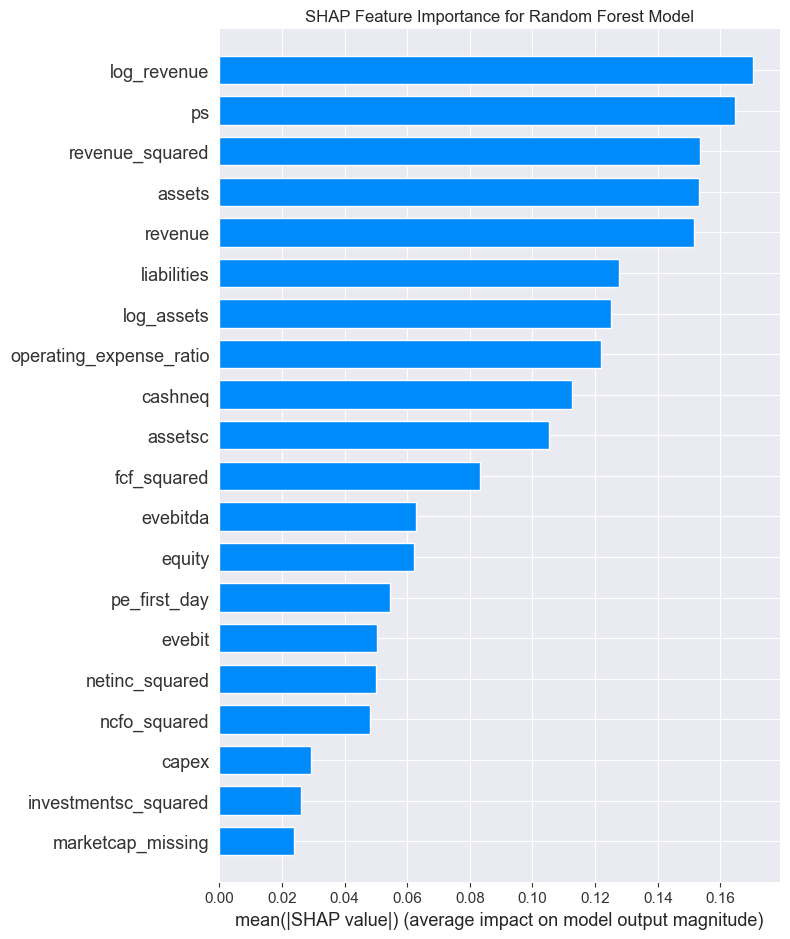


SHAP Value Statistics:
                    feature  mean_abs_shap  std_shap  max_abs_shap
8               log_revenue       0.170489  0.195090      0.503559
14                       ps       0.164499  0.212024      1.238678
58          revenue_squared       0.153579  0.177523      0.554798
18                   assets       0.153000  0.177027      0.530014
3                   revenue       0.151475  0.171096      0.505128
37              liabilities       0.127774  0.145679      0.521282
12               log_assets       0.125004  0.144838      0.427168
41  operating_expense_ratio       0.121753  0.138661      0.397500
35                  cashneq       0.112590  0.119420      0.317330
25                  assetsc       0.105419  0.115746      0.287166
59              fcf_squared       0.083258  0.093441      0.318860
26                 evebitda       0.062779  0.084967      0.793233
16                   equity       0.062296  0.070555      0.252167
61             pe_first_day       0.05

<Figure size 1200x800 with 0 Axes>

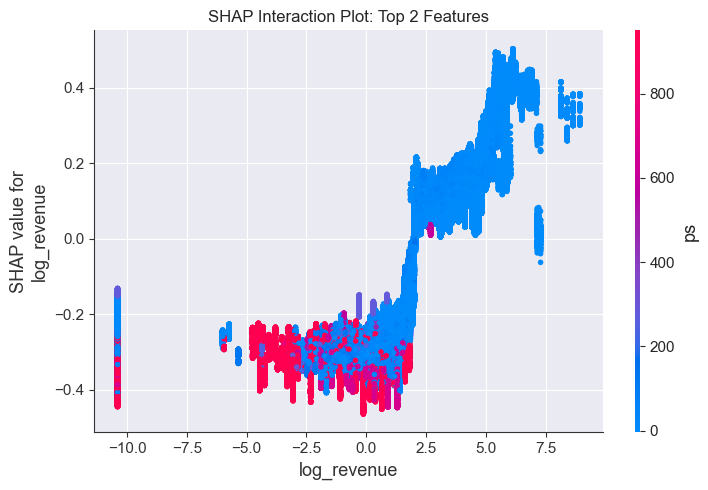

In [3]:
 import shap 
# Initialize SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Create summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Random Fo st Model")
plt.tight_layout()
plt.savefig('rf_shap_summary.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display SHAP statistics
shap_stats = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.mean(np.abs(shap_values), axis=0),
    'std_shap': np.std(shap_values, axis=0),
    'max_abs_shap': np.max(np.abs(shap_values), axis=0)
})

shap_stats = shap_stats.sort_values('mean_abs_shap', ascending=False)
print("\nSHAP Value Statistics:")
print(shap_stats.head(15))

plt.figure(figsize=(12, 8))
shap.dependence_plot(
    shap_stats.iloc[0]['feature'],
    shap_values,
    X_test,
    interaction_index=shap_stats.iloc[1]['feature'],
    show=False
)
plt.title(f"SHAP Interaction Plot: Top 2 Features")
plt.tight_layout()
plt.savefig('rf_shap_interaction.jpg', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1000x1200 with 0 Axes>

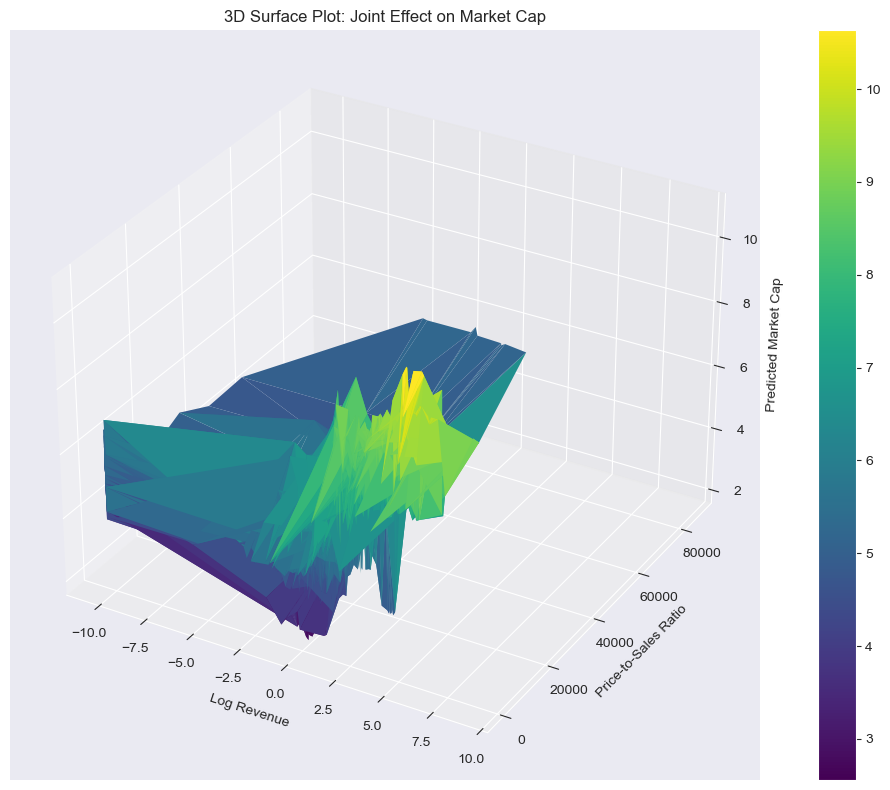

C:\Users\Katarina\AppData\Local\Temp\ipykernel_16780\4092313908.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conditional_means = interaction_stats.groupby(pd.qcut(interaction_stats['log_revenue'], 5))['predicted_market_cap'].mean()
C:\Users\Katarina\AppData\Local\Temp\ipykernel_16780\4092313908.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conditional_impact = interaction_stats.groupby(pd.qcut(interaction_stats['ps'], 5))['predicted_market_cap'].mean()



Feature Interaction Statistics:

Correlation Matrix:
                      log_revenue        ps  predicted_market_cap
log_revenue              1.000000 -0.177654              0.609175
ps                      -0.177654  1.000000             -0.089506
predicted_market_cap     0.609175 -0.089506              1.000000

Joint Distribution Summary:

Mean:
log_revenue                1.953194
ps                      1003.320789
predicted_market_cap       6.291828
dtype: float64

Median:
log_revenue             2.675786
ps                      3.700000
predicted_market_cap    6.550600
dtype: float64

Std:
log_revenue                3.007995
ps                      7885.713772
predicted_market_cap       1.728966
dtype: float64

Min:
log_revenue             -10.392857
ps                     -294.300000
predicted_market_cap      1.762007
dtype: float64

Max:
log_revenue                 8.922342
ps                      86395.100000
predicted_market_cap       11.151624
dtype: float64

Q1:
log_reve

In [23]:
# 3D Surface Plot with same feature pair
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

x = X_test['log_revenue'].values
y = X_test['ps'].values
z = rf_model.predict(X_test)

surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
ax.set_xlabel('Log Revenue')
ax.set_ylabel('Price-to-Sales Ratio')
ax.set_zlabel('Predicted Market Cap')
plt.colorbar(surf)
plt.title('3D Surface Plot: Joint Effect on Market Cap')
plt.tight_layout()
plt.savefig('3d_surface_25M.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Calculate statistical measures for the feature interactions
interaction_stats = pd.DataFrame({
    'log_revenue': x,
    'ps': y,
    'predicted_market_cap': z
})

# Generate key statistics
stats_summary = {
    'Correlation': interaction_stats.corr(),
    'Joint_Distribution': {
        'Mean': interaction_stats.mean(),
        'Median': interaction_stats.median(),
        'Std': interaction_stats.std(),
        'Min': interaction_stats.min(),
        'Max': interaction_stats.max(),
        'Q1': interaction_stats.quantile(0.25),
        'Q3': interaction_stats.quantile(0.75)
    },
    'Value_Ranges': {
        'log_revenue_bins': pd.qcut(x, q=5).value_counts(),
        'ps_bins': pd.qcut(y, q=5).value_counts()
    }
}

# Calculate conditional statistics
conditional_means = interaction_stats.groupby(pd.qcut(interaction_stats['log_revenue'], 5))['predicted_market_cap'].mean()
conditional_impact = interaction_stats.groupby(pd.qcut(interaction_stats['ps'], 5))['predicted_market_cap'].mean()

print("\nFeature Interaction Statistics:")
print("\nCorrelation Matrix:")
print(stats_summary['Correlation'])
print("\nJoint Distribution Summary:")
for metric, values in stats_summary['Joint_Distribution'].items():
    print(f"\n{metric}:")
    print(values)
print("\nConditional Market Cap by Log Revenue Quintiles:")
print(conditional_means)
print("\nConditional Market Cap by PS Quintiles:")
print(conditional_impact)

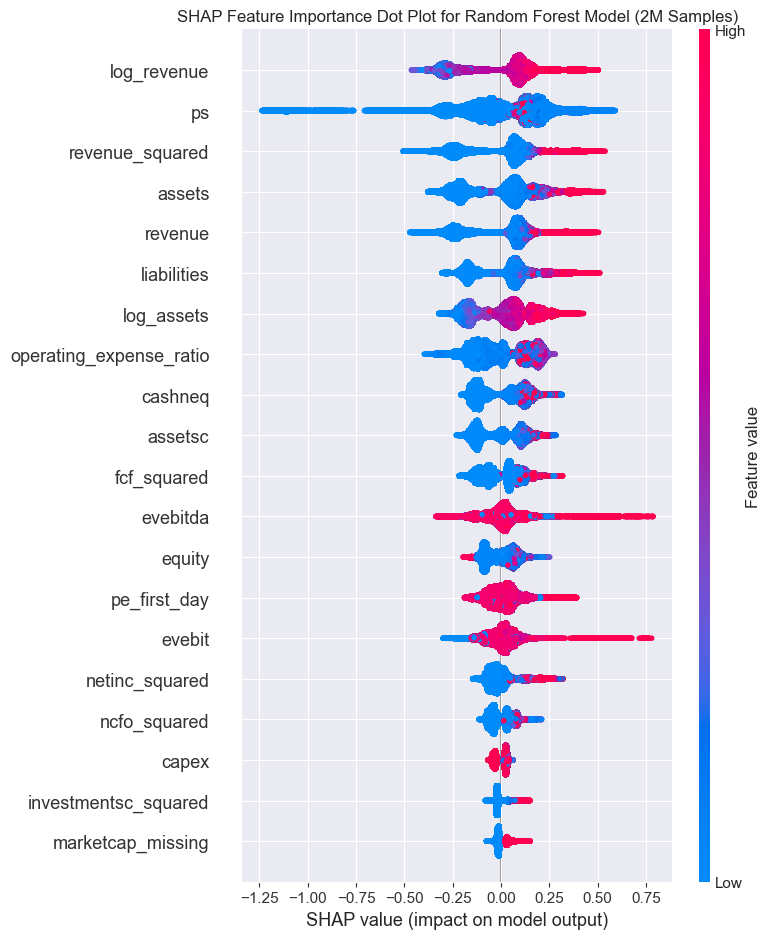

In [8]:
plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values[:2_000_000],
    X_test[:2_000_000],
    plot_type="dot",
    show=False,
    max_display=20 
)
plt.title("SHAP Feature Importance Dot Plot for Random Forest Model (2M Samples)")
plt.tight_layout()
plt.savefig('rf_shap_dot_summary_2M.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate prediction and actual value for our samples
sample_idx = 0
high_pred_idx = np.argmax(rf_model.predict(X_test))

# Create statistics dataframe for both cases
def get_prediction_stats(idx):
    prediction = rf_model.predict(X_test.iloc[idx:idx+1])[0]
    actual = y_test.iloc[idx]
    feature_contributions = pd.DataFrame({
        'Feature': X_test.columns,
        'SHAP_value': shap_values[idx],
        'Feature_value': X_test.iloc[idx].values,
        'Abs_impact': abs(shap_values[idx])
    })
    feature_contributions = feature_contributions.sort_values('Abs_impact', ascending=False)

    stats = {
        'Base_value': explainer.expected_value,
        'Prediction': prediction,
        'Actual_value': actual,
        'Difference': prediction - actual,
        'Total_SHAP_impact': np.sum(shap_values[idx])
    }

    return stats, feature_contributions

# Get stats for typical case
typical_stats, typical_contributions = get_prediction_stats(sample_idx)
print("\nTypical Case Statistics:")
print(pd.Series(typical_stats))
print("\nTop 10 Feature Contributions (Typical Case):")
print(typical_contributions.head(10))

# Get stats for high-value case
high_stats, high_contributions = get_prediction_stats(high_pred_idx)
print("\nHigh Value Case Statistics:")
print(pd.Series(high_stats))
print("\nTop 10 Feature Contributions (High Value Case):")
print(high_contributions.head(10))

# Calculate comparative statistics
# Calculate comparative statistics - fixed version
comparative_analysis = pd.DataFrame({
    'Typical_case': typical_contributions.set_index('Feature')['SHAP_value'],
    'High_value_case': high_contributions.set_index('Feature')['SHAP_value']
})
print("\nComparative Feature Impact Analysis:")
print(comparative_analysis.head(10))


Typical Case Statistics:
Base_value           [6.29249094928797]
Prediction                     4.313112
Actual_value                   4.506454
Difference                    -0.193343
Total_SHAP_impact             -1.979379
dtype: object

Top 10 Feature Contributions (Typical Case):
                    Feature  SHAP_value  Feature_value  Abs_impact
8               log_revenue   -0.304004      -2.856019    0.304004
3                   revenue   -0.270150      -0.702200    0.270150
58          revenue_squared   -0.252675       0.493084    0.252675
18                   assets   -0.214757       1.557396    0.214757
37              liabilities   -0.179430      -5.328707    0.179430
12               log_assets   -0.162109       1.510840    0.162109
14                       ps    0.131089     593.300000    0.131089
26                 evebitda   -0.110326     -26.400000    0.110326
41  operating_expense_ratio    0.109041       4.370116    0.109041
35                  cashneq   -0.107734     

In [22]:
def get_prediction_stats(idx):
    prediction = rf_model.predict(X_test.iloc[idx:idx+1])[0]
    actual = y_test.iloc[idx]
    feature_contributions = pd.DataFrame({
        'Feature': X_test.columns,
        'SHAP_value': shap_values[idx],
        'Feature_value': X_test.iloc[idx].values,
        'Abs_impact': abs(shap_values[idx]),
        'Relative_impact': abs(shap_values[idx]) / np.sum(abs(shap_values[idx])) * 100,  # Percentage impact
        'Direction': np.where(shap_values[idx] > 0, 'Positive', 'Negative')
    })

    feature_contributions = feature_contributions.sort_values('Abs_impact', ascending=False)

    stats = {
        'Base_value': explainer.expected_value,
        'Prediction': prediction,
        'Actual_value': actual,
        'Difference': prediction - actual,
        'Prediction_accuracy': (1 - abs(prediction - actual)/actual) * 100,  # Accuracy percentage
        'Total_SHAP_impact': np.sum(shap_values[idx]),
        'Total_absolute_impact': np.sum(abs(shap_values[idx])),
        'Positive_features': (shap_values[idx] > 0).sum(),
        'Negative_features': (shap_values[idx] < 0).sum()
    }

    return stats, feature_contributions

# Get enhanced statistics
typical_stats, typical_contributions = get_prediction_stats(sample_idx)
high_stats, high_contributions = get_prediction_stats(high_pred_idx)

# Create comparative analysis with additional metrics
comparative_analysis = pd.DataFrame({
    'Typical_case_SHAP': typical_contributions['SHAP_value'],
    'Typical_case_relative_impact': typical_contributions['Relative_impact'],
    'High_value_case_SHAP': high_contributions['SHAP_value'],
    'High_value_case_relative_impact': high_contributions['Relative_impact'],
    'Impact_difference': abs(typical_contributions['SHAP_value'] - high_contributions['SHAP_value']),
    'Direction_change': typical_contributions['SHAP_value'] * high_contributions['SHAP_value'] < 0
})

# Print enhanced analysis
print("\nTypical Case Statistics:")
print(pd.Series(typical_stats))
print("\nTop 10 Feature Contributions (Typical Case):")
print(typical_contributions.head(10))
print("\nHigh Value Case Statistics:")
print(pd.Series(high_stats))
print("\nTop 10 Feature Contributions (High Value Case):")
print(high_contributions.head(10))
print("\nComparative Feature Impact Analysis:")
print(comparative_analysis.head(10))

# Calculate summary statistics
print("\nSummary Statistics:")
print(f"Features with direction change: {comparative_analysis['Direction_change'].sum()}")
print(f"Top 5 features by impact difference:")
print(comparative_analysis.nlargest(5, 'Impact_difference')[['Impact_difference']])


Typical Case Statistics:
Base_value               [6.29249094928797]
Prediction                         4.313112
Actual_value                       4.506454
Difference                        -0.193343
Prediction_accuracy               95.709649
Total_SHAP_impact                 -1.979379
Total_absolute_impact              2.595772
Positive_features                        20
Negative_features                        42
dtype: object

Top 10 Feature Contributions (Typical Case):
                    Feature  SHAP_value  Feature_value  Abs_impact  \
8               log_revenue   -0.304004      -2.856019    0.304004   
3                   revenue   -0.270150      -0.702200    0.270150   
58          revenue_squared   -0.252675       0.493084    0.252675   
18                   assets   -0.214757       1.557396    0.214757   
37              liabilities   -0.179430      -5.328707    0.179430   
12               log_assets   -0.162109       1.510840    0.162109   
14                       ps 

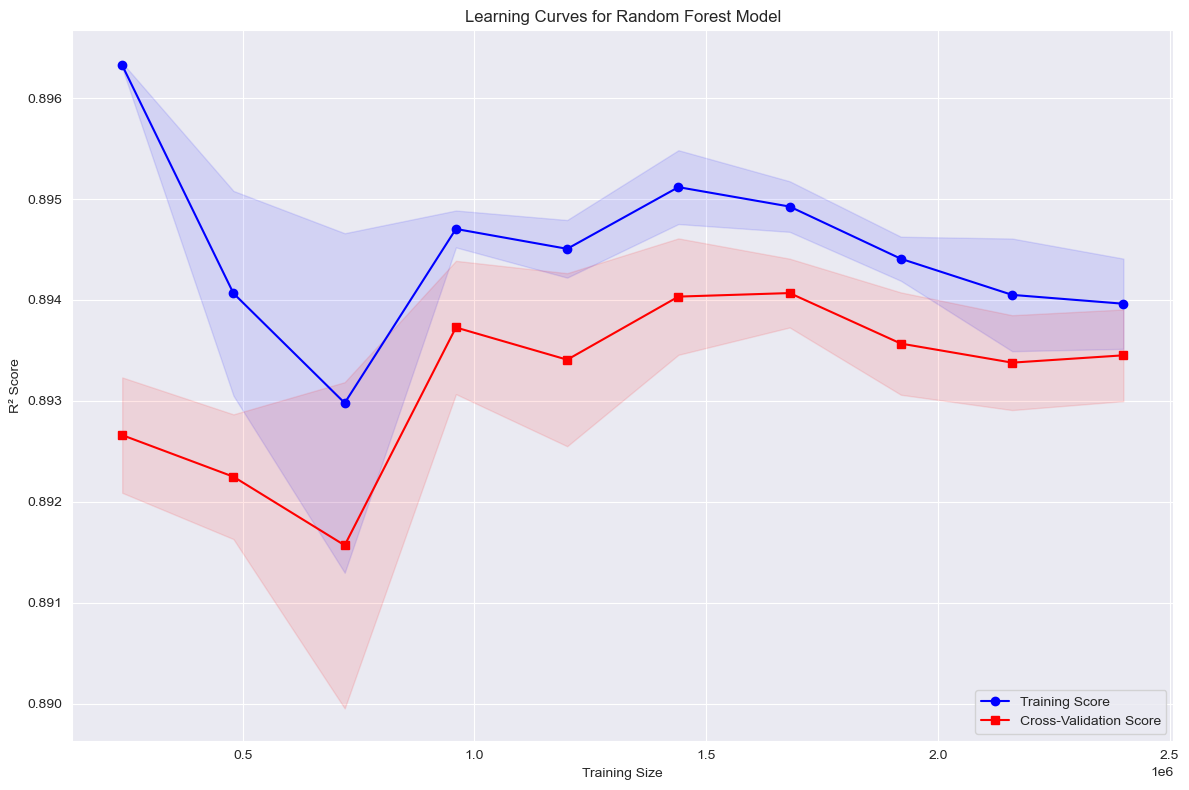


Learning Curve Statistics:
   Training_Size  Training_Score_Mean  Training_Score_Std  \
0         240000             0.896324            0.000026   
1         480000             0.894066            0.001014   
2         720000             0.892979            0.001681   
3         960000             0.894703            0.000183   
4        1200000             0.894507            0.000285   
5        1440000             0.895118            0.000366   
6        1680000             0.894925            0.000251   
7        1920000             0.894408            0.000218   
8        2160000             0.894050            0.000558   
9        2400000             0.893963            0.000447   

   Validation_Score_Mean  Validation_Score_Std  
0               0.892661              0.000571  
1               0.892249              0.000618  
2               0.891570              0.001616  
3               0.893727              0.000660  
4               0.893408              0.000857  
5     

In [25]:
# Create a random sample of the data
sample_size = 3000000
random_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[random_indices]
y_sample = y_train.iloc[random_indices]

# Generate learning curves with the sample
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X_sample,
    y_sample,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Calculate statistics
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Create visualization
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, val_mean, label='Cross-Validation Score', color='red', marker='s')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title('Learning Curves for Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('learning_curves.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print numerical results
results_df = pd.DataFrame({
    'Training_Size': train_sizes,
    'Training_Score_Mean': train_mean,
    'Training_Score_Std': train_std,
    'Validation_Score_Mean': val_mean,
    'Validation_Score_Std': val_std
})
print("\nLearning Curve Statistics:")
print(results_df)

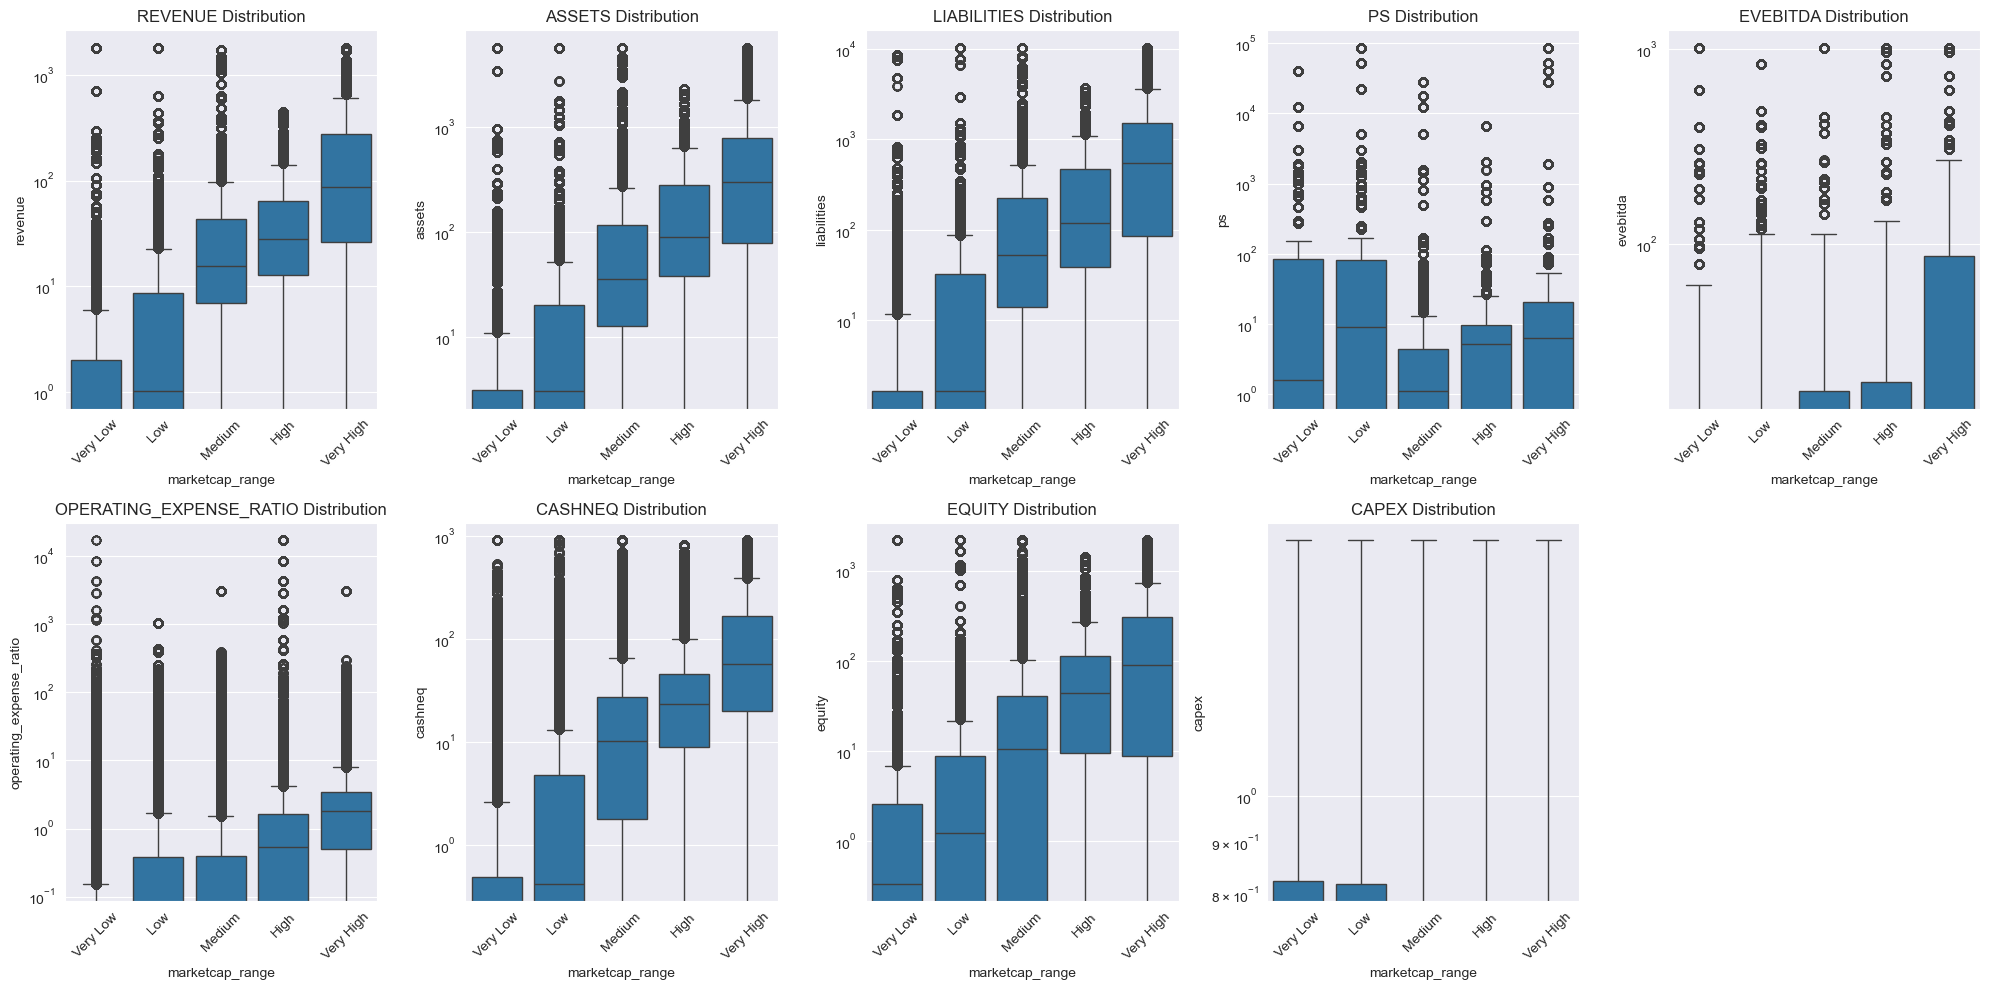


=== REVENUE Statistics by Market Cap Range ===
                   Count     Mean      Std    Min     25%  Median      75%  \
marketcap_range                                                              
Very Low         4081712   11.027   51.648 -0.706  -0.626  -0.191    2.001   
Low              4031422    8.835   34.486 -0.706  -0.593   1.012    8.692   
Medium           3925317   47.648  103.482 -0.706   6.866  15.683   43.459   
High             4055163   59.855   83.234 -0.706  12.879  28.098   64.429   
Very High        3906386  309.927  511.915 -0.706  26.134  86.604  272.868   

                      Max  Skewness  Kurtosis  
marketcap_range                                
Very Low         1811.427    13.598   386.251  
Low              1811.427    32.955  1603.439  
Medium           1719.100     6.234    58.365  
High              442.426     2.580     6.838  
Very High        1811.427     2.119     3.182  

=== ASSETS Statistics by Market Cap Range ===
                   Cou

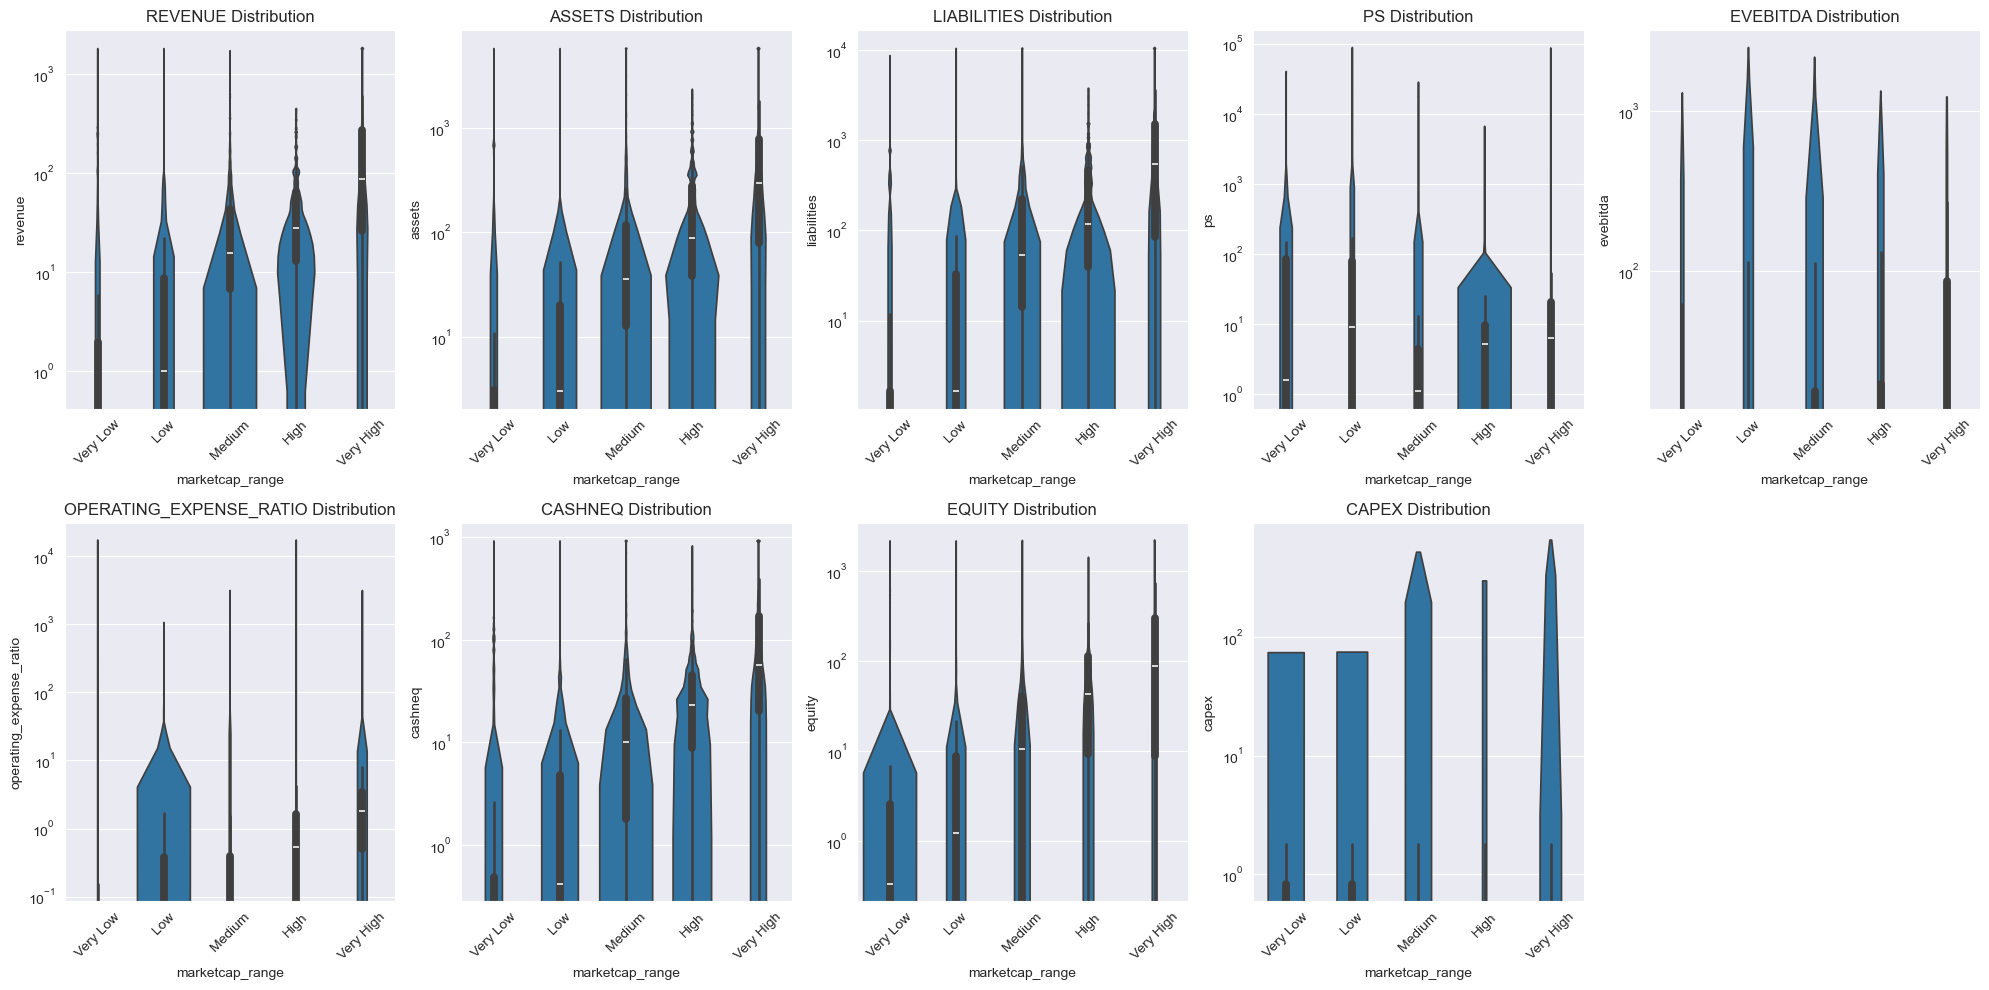

In [30]:
# Create visualization dataframe
viz_df = X_train.copy()
viz_df['log_marketcap'] = y_train
viz_df['marketcap_range'] = pd.qcut(viz_df['log_marketcap'], q=5,
                                    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Define key features
key_features = ['revenue', 'assets', 'liabilities', 'ps', 'evebitda',
                'operating_expense_ratio', 'cashneq', 'equity', 'capex']

# Box plots with statistics
plt.figure(figsize=(20, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(x='marketcap_range', y=feature, data=viz_df)
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.title(f'{feature.upper()} Distribution')
plt.tight_layout()
plt.savefig('boxplots_distribution1.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print comprehensive statistics with observed=True
for feature in key_features:
    print(f"\n=== {feature.upper()} Statistics by Market Cap Range ===")
    stats = viz_df.groupby('marketcap_range', observed=True)[feature].agg([
        'count', 'mean', 'std', 'min',
        lambda x: x.quantile(0.25),
        'median',
        lambda x: x.quantile(0.75),
        'max',
        lambda x: x.skew(),
        lambda x: x.kurtosis()
    ]).round(3)
    stats.columns = ['Count', 'Mean', 'Std', 'Min', '25%', 'Median', '75%', 'Max', 'Skewness', 'Kurtosis']
    print(stats)

# Violin plots
plt.figure(figsize=(20, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 5, i)
    sns.violinplot(x='marketcap_range', y=feature, data=viz_df)
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.title(f'{feature.upper()} Distribution')
plt.tight_layout()
plt.savefig('violin_distribution1.jpg', dpi=300, bbox_inches='tight')
plt.show()

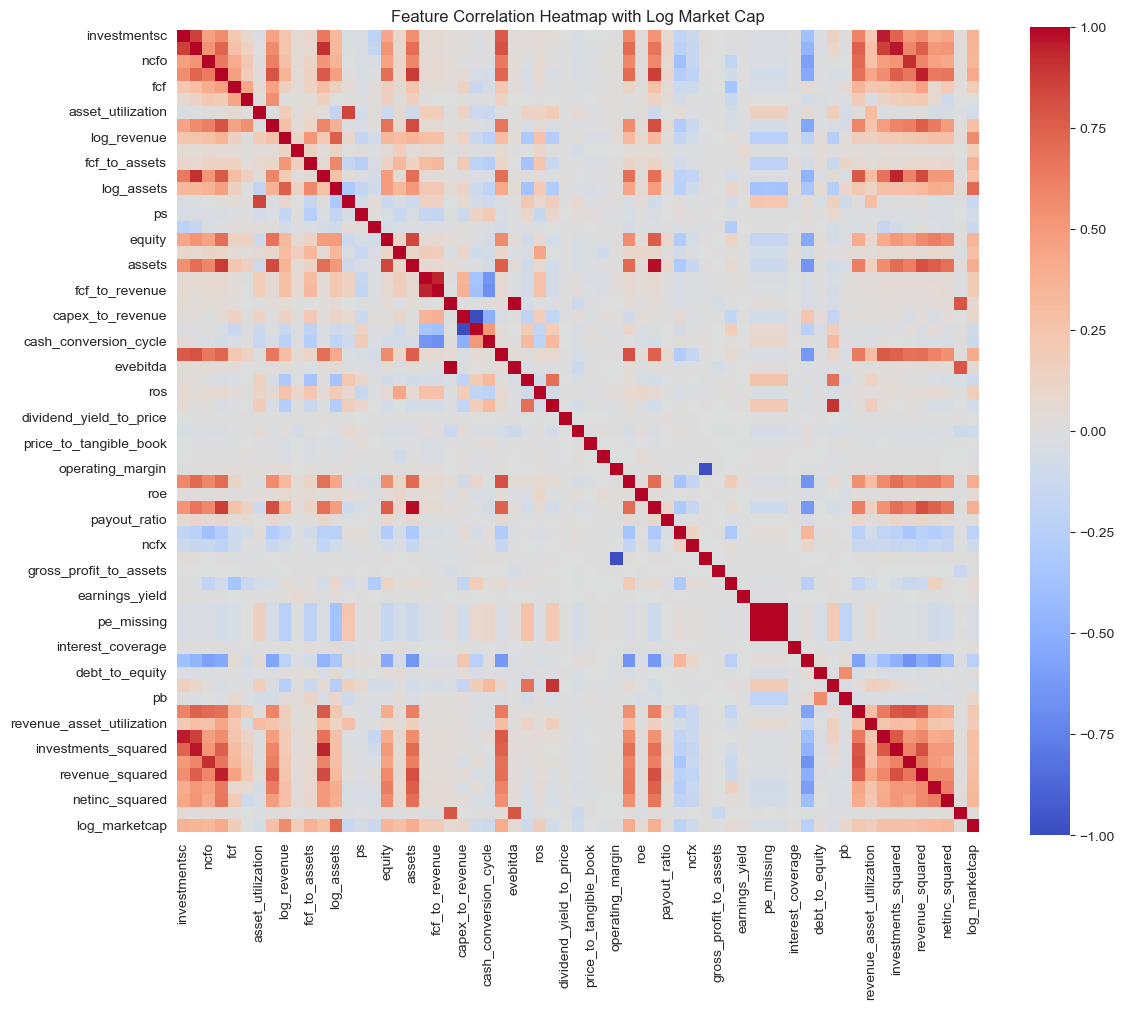

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\updated_preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

# Read the data
features_df = pd.read_parquet(features_path)
y_df = pd.read_parquet(target_path)

# Combine features with target variable
y = np.log(y_df['marketcap_first_day'])
combined_df = pd.concat([features_df, pd.Series(y, name='log_marketcap')], axis=1)

# Create correlation matrix
correlation_matrix = combined_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=False,  # Removed the numerical annotations
            cmap='coolwarm',
            center=0,
            square=True)

plt.title('Feature Correlation Heatmap with Log Market Cap')
plt.tight_layout()
plt.savefig('correlation_heatmap_clean.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
import pandas as pd
import numpy as np

# Define the file paths
features_path = r'C:\Users\Katarina\OneDrive\Desktop\updated_preprocessed_features.parquet'
target_path = r'C:\Users\Katarina\OneDrive\Desktop\target_variable.parquet'

features_df = pd.read_parquet(features_path)
y_df = pd.read_parquet(target_path)

# Combine features with target variable
y = np.log(y_df['marketcap_first_day'])
combined_df = pd.concat([features_df, pd.Series(y, name='log_marketcap')], axis=1)

# Calculate correlations
correlations = combined_df.corr()['log_marketcap'].sort_values(ascending=False)

# Create a summary DataFrame
correlation_stats = pd.DataFrame({
    'Feature': correlations.index,
    'Correlation with log_marketcap': correlations.values
})

# Display top correlations
print("Top positive and negative correlations with log_marketcap:")
print(correlation_stats)

Top positive and negative correlations with log_marketcap:
                  Feature  Correlation with log_marketcap
0           log_marketcap                        1.000000
1              log_assets                        0.711892
2             log_revenue                        0.563178
3                 revenue                        0.418196
4                 assetsc                        0.405095
..                    ...                             ...
58  cash_conversion_cycle                       -0.119798
59                 ncfinv                       -0.131422
60         asset_turnover                       -0.144851
61                 ncfbus                       -0.218805
62                  capex                       -0.240715

[63 rows x 2 columns]


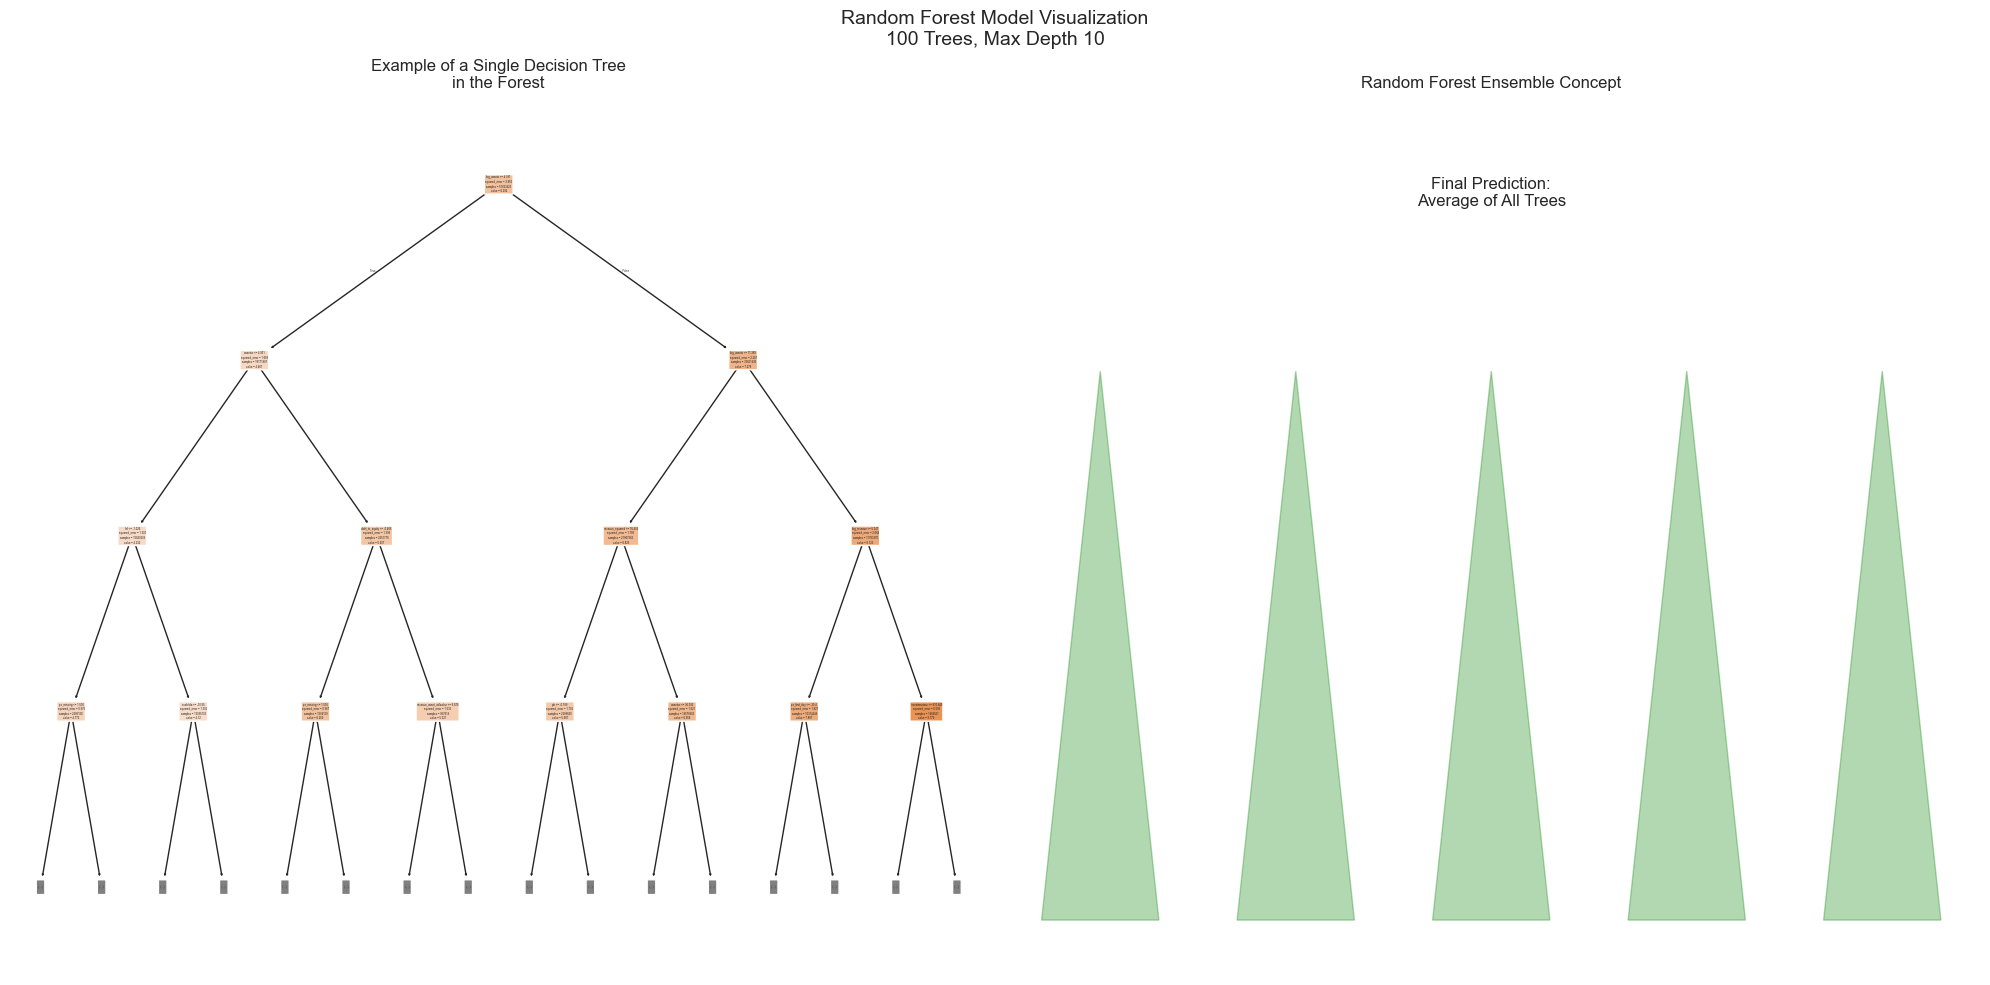

In [4]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define and create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100,
                                 max_depth=10,
                                 min_samples_split=5,
                                 min_samples_leaf=2,
                                 max_features='sqrt',
                                 n_jobs=-1,
                                 random_state=42)

# Fit the model to your data
rf_model.fit(features_df, y)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot a single tree from the forest (left subplot)
plot_tree(rf_model.estimators_[0],
          max_depth=3,
          feature_names=features_df.columns,
          filled=True,
          rounded=True,
          ax=ax1)
ax1.set_title('Example of a Single Decision Tree\nin the Forest', fontsize=12)

# Create a visual representation of multiple trees (right subplot)
def plot_forest_concept(ax):
    n_trees = 5
    for i in range(n_trees):
        x = np.array([i-0.3, i+0.3, i])
        y = np.array([0, 0, 1])
        ax.fill(x, y, alpha=0.3, color='green')

    ax.set_xlim(-0.5, n_trees-0.5)
    ax.set_ylim(-0.1, 1.5)
    ax.text(n_trees/2-0.5, 1.3, 'Final Prediction:\nAverage of All Trees',
            ha='center', fontsize=12)
    ax.axis('off')

plot_forest_concept(ax2)
ax2.set_title('Random Forest Ensemble Concept', fontsize=12)

plt.suptitle('Random Forest Model Visualization\n100 Trees, Max Depth 10', fontsize=14)
plt.tight_layout()
plt.savefig('random_forest_visualization.jpg', dpi=300, bbox_inches='tight')
plt.show()

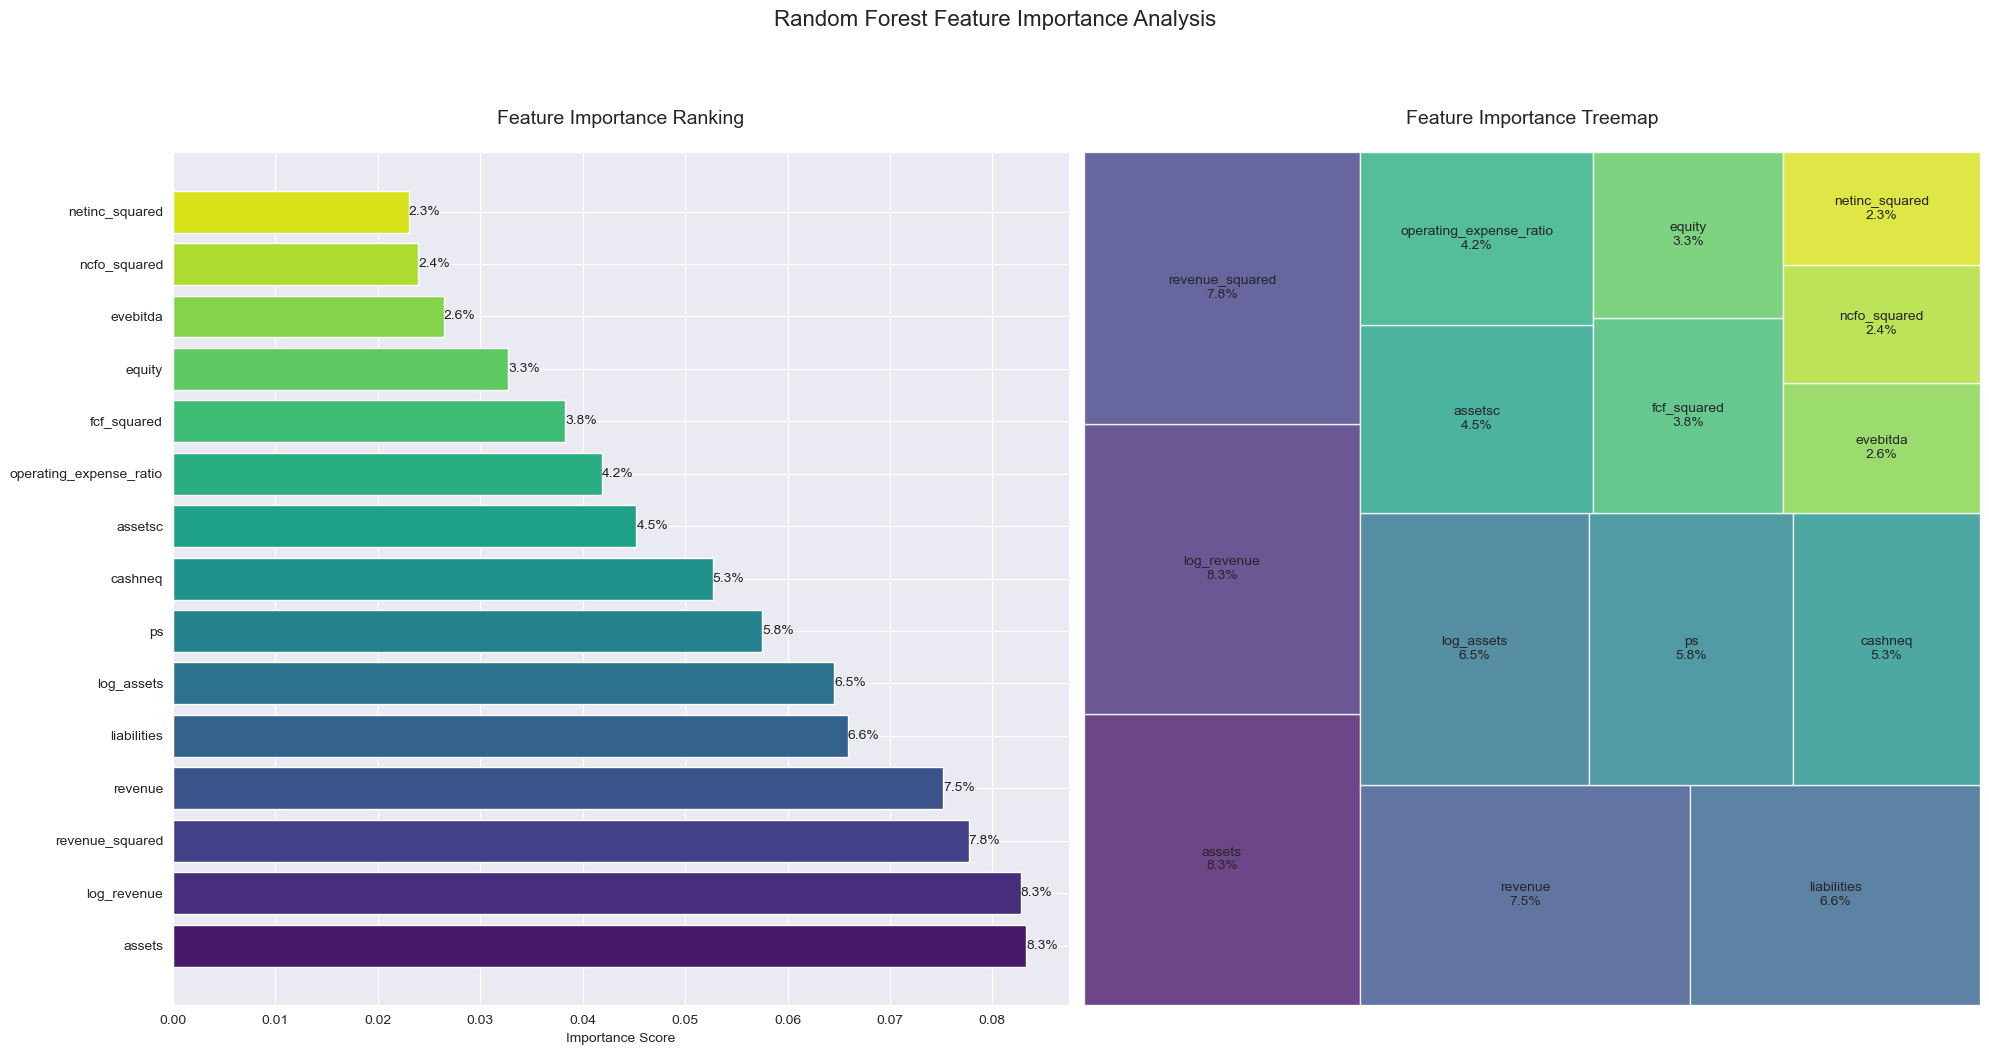

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame with the feature importance data
importance_data = pd.DataFrame({
    'feature': ['assets', 'log_revenue', 'revenue_squared', 'revenue', 'liabilities',
                'log_assets', 'ps', 'cashneq', 'assetsc', 'operating_expense_ratio',
                'fcf_squared', 'equity', 'evebitda', 'ncfo_squared', 'netinc_squared'],
    'importance': [0.083306, 0.082760, 0.077697, 0.075198, 0.065881,
                   0.064566, 0.057526, 0.052697, 0.045258, 0.041879,
                   0.038270, 0.032748, 0.026424, 0.023979, 0.023052]
})

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 10))

# 1. Horizontal bar plot with gradient color
plt.subplot(121)
colors = sns.color_palette("viridis", len(importance_data))
bars = plt.barh(importance_data['feature'], importance_data['importance'],
                color=colors)
plt.title('Feature Importance Ranking', fontsize=14, pad=20)
plt.xlabel('Importance Score')

# Add percentage labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width*100:.1f}%',
             ha='left', va='center', fontsize=10)

# 2. Treemap visualization
import squarify
plt.subplot(122)
sizes = importance_data['importance'] * 100
labels = [f'{feat}\n{imp:.1f}%' for feat, imp in
          zip(importance_data['feature'], sizes)]
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=colors)
plt.axis('off')
plt.title('Feature Importance Treemap', fontsize=14, pad=20)

plt.suptitle('Random Forest Feature Importance Analysis', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('feature_importance_treeanalysis1.jpg', dpi=300, bbox_inches='tight')
plt.show()

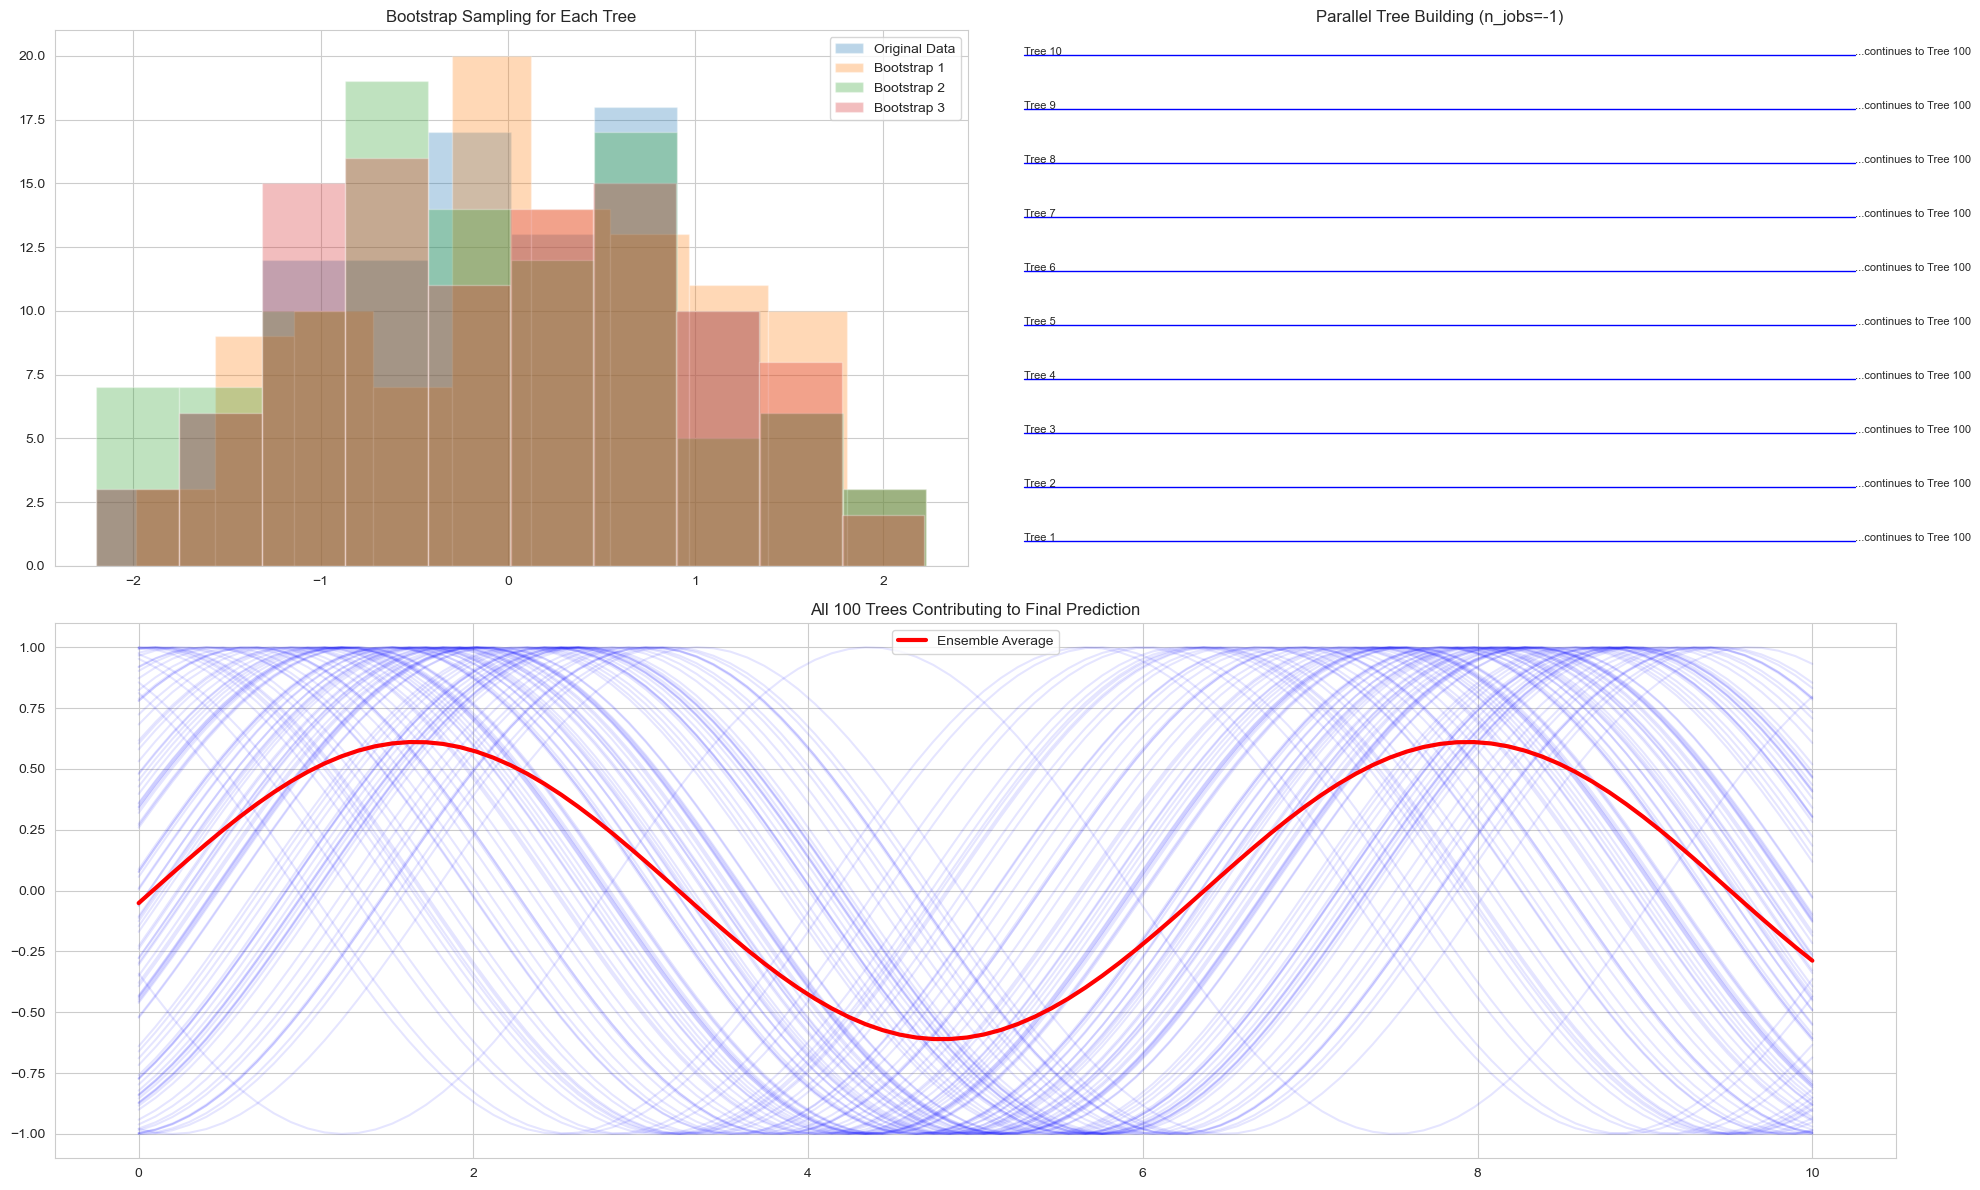

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 12))

# 1. Bootstrap Sampling Process
plt.subplot(221)
n_samples = 100
original_data = np.random.randn(n_samples)
bootstrap_samples = [np.random.choice(original_data, size=n_samples, replace=True)
                     for _ in range(3)]  # Showing 3 example bootstrap samples

plt.hist(original_data, alpha=0.3, label='Original Data')
for i, sample in enumerate(bootstrap_samples):
    plt.hist(sample, alpha=0.3, label=f'Bootstrap {i+1}')
plt.title('Bootstrap Sampling for Each Tree')
plt.legend()

# 2. Parallel Tree Building
plt.subplot(222)
def plot_parallel_trees():
    for i in range(10):  # Showing 10 parallel processes
        y_base = i * 2
        plt.plot([0, 5], [y_base, y_base], 'b-', linewidth=1)
        plt.text(0, y_base, f'Tree {i+1}', fontsize=8)
        plt.text(5, y_base, '...continues to Tree 100', fontsize=8)

plot_parallel_trees()
plt.title('Parallel Tree Building (n_jobs=-1)')
plt.axis('off')

# 3. Final Ensemble Prediction
plt.subplot(212)
x = np.linspace(0, 10, 100)
predictions = [np.sin(x + np.random.randn()) for _ in range(100)]
for pred in predictions:
    plt.plot(x, pred, 'b-', alpha=0.1)
plt.plot(x, np.mean(predictions, axis=0), 'r-', linewidth=3, label='Ensemble Average')
plt.title('All 100 Trees Contributing to Final Prediction')
plt.legend()

plt.tight_layout()
plt.savefig('actual_rf_process.jpg', dpi=300, bbox_inches='tight')
plt.show()

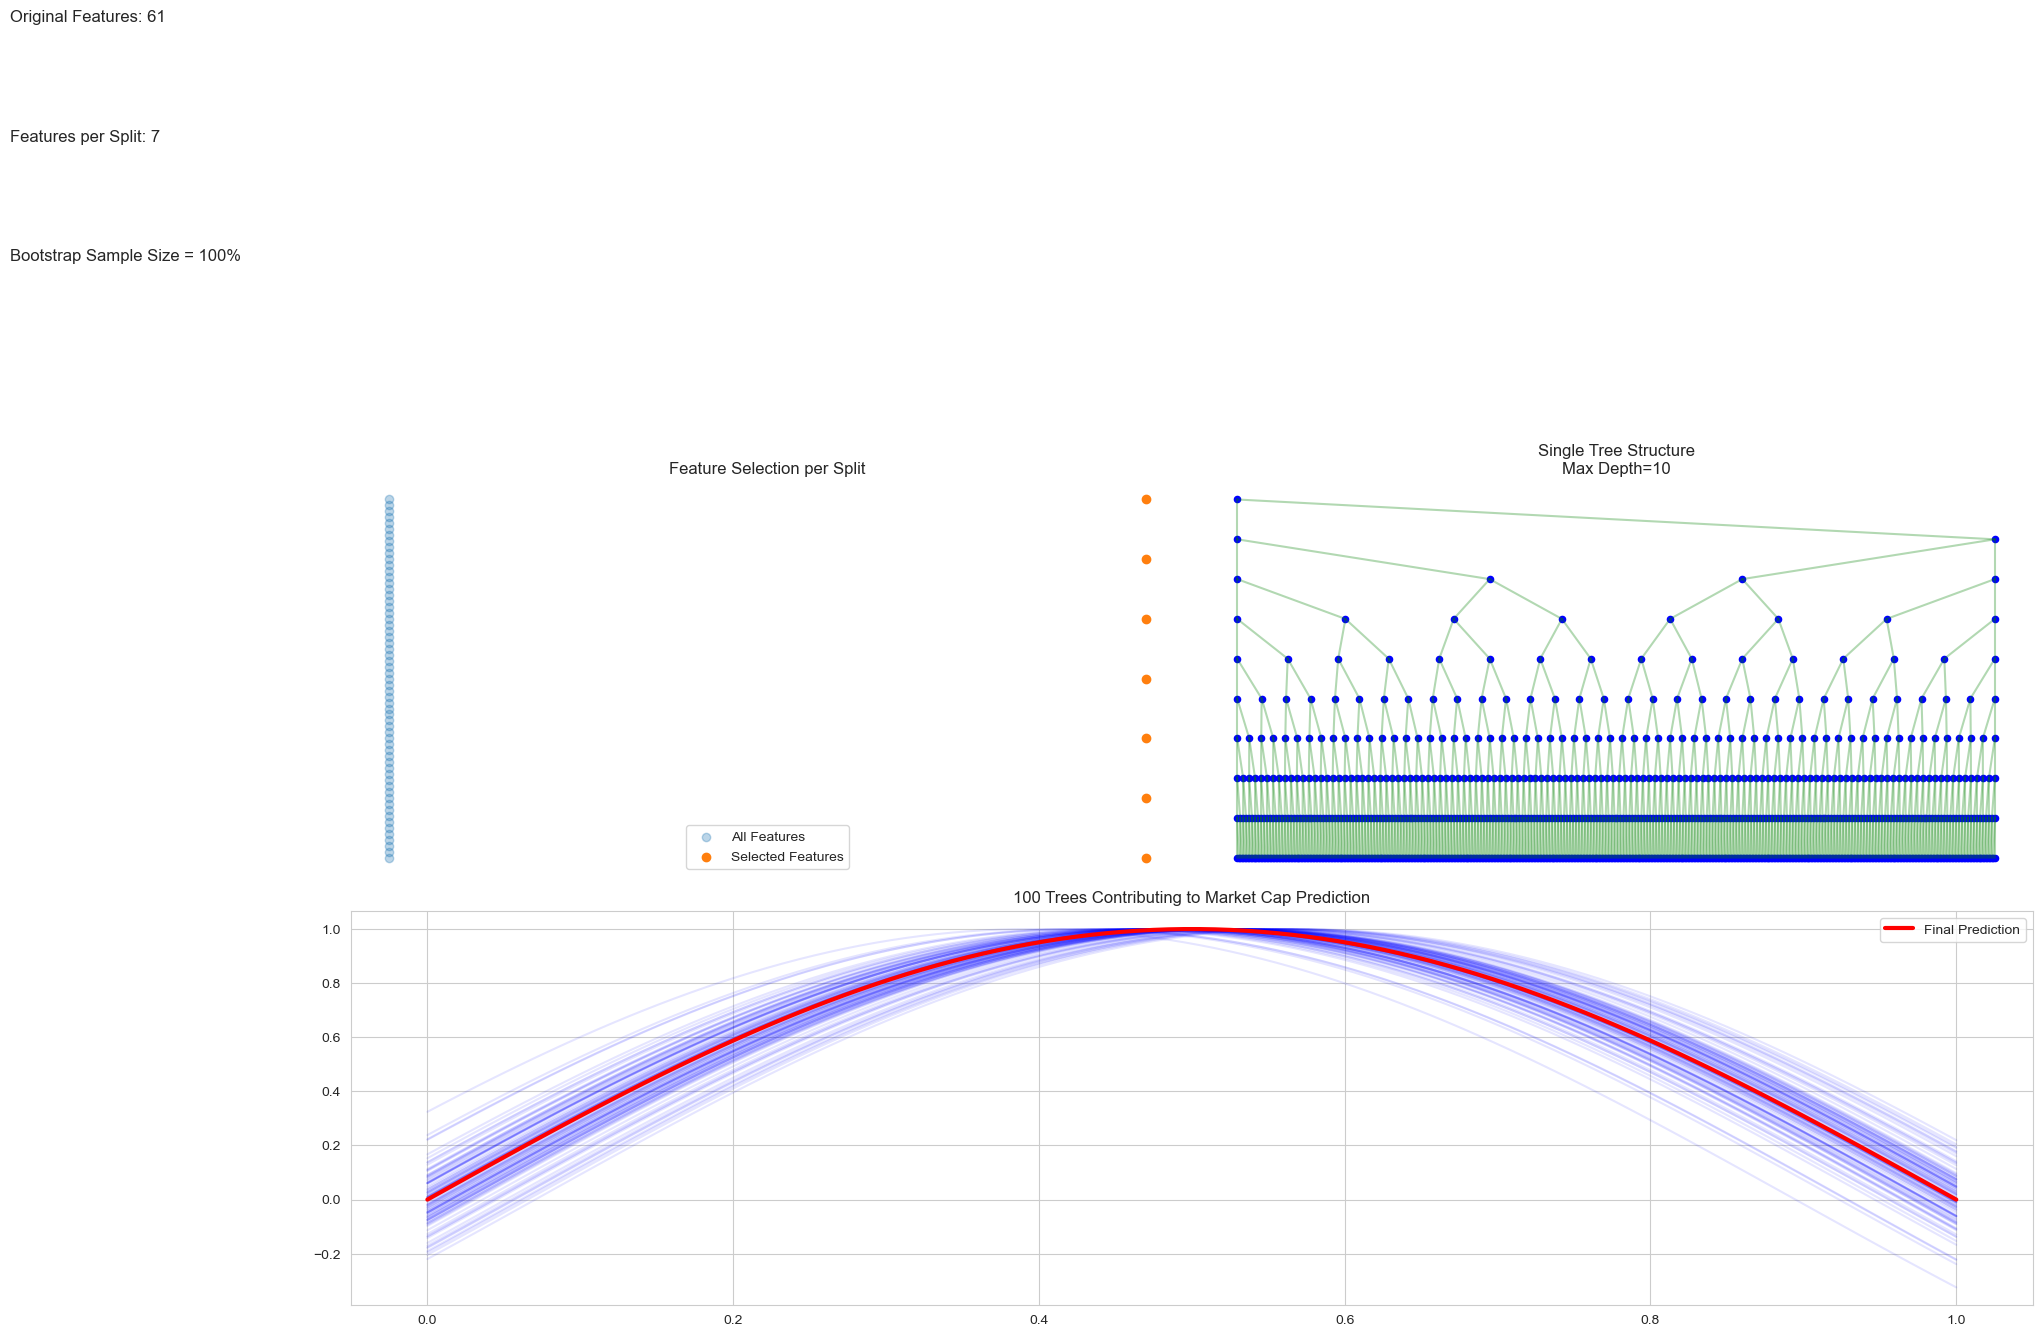

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 15))

# 1. Data Bootstrap Process
plt.subplot(221)
n_features = 61  # Your actual number of features
n_sqrt = int(np.sqrt(n_features))

plt.text(0.1, 0.8, f"Original Features: {n_features}", fontsize=12)
plt.text(0.1, 0.7, f"Features per Split: {n_sqrt}", fontsize=12)
plt.text(0.1, 0.6, "Bootstrap Sample Size = 100%", fontsize=12)

# Visualize feature selection
plt.scatter([0.2]*n_features, np.linspace(0.1, 0.4, n_features),
            alpha=0.3, label='All Features')
plt.scatter([0.4]*n_sqrt, np.linspace(0.1, 0.4, n_sqrt),
            alpha=1.0, label='Selected Features')
plt.legend()
plt.title("Feature Selection per Split")
plt.axis('off')

# 2. Single Tree Structure (Depth=10)
plt.subplot(222)
levels = 10  # max_depth
for level in range(levels):
    y = 1 - level/levels
    nodes = 2**level
    x_positions = np.linspace(0.1, 0.9, nodes)
    plt.scatter(x_positions, [y]*nodes, c='blue', s=20)
    if level < levels-1:
        for i, x in enumerate(x_positions):
            next_y = 1 - (level+1)/levels
            next_x = np.linspace(0.1, 0.9, 2**(level+1))
            plt.plot([x, next_x[2*i]], [y, next_y], 'g-', alpha=0.3)
            plt.plot([x, next_x[2*i+1]], [y, next_y], 'g-', alpha=0.3)
plt.title(f"Single Tree Structure\nMax Depth={10}")
plt.axis('off')

# 3. Ensemble Prediction Process
plt.subplot(212)
x = np.linspace(0, 1, 100)
for i in range(100):  # All 100 trees
    y = np.sin(x * np.pi + np.random.normal(0, 0.1))
    plt.plot(x, y, 'b-', alpha=0.1)
plt.plot(x, np.sin(x * np.pi), 'r-', linewidth=3, label='Final Prediction')
plt.title("100 Trees Contributing to Market Cap Prediction")
plt.legend()

plt.tight_layout()
plt.savefig('rf_marketcap_prediction.jpg', dpi=300, bbox_inches='tight')
plt.show()

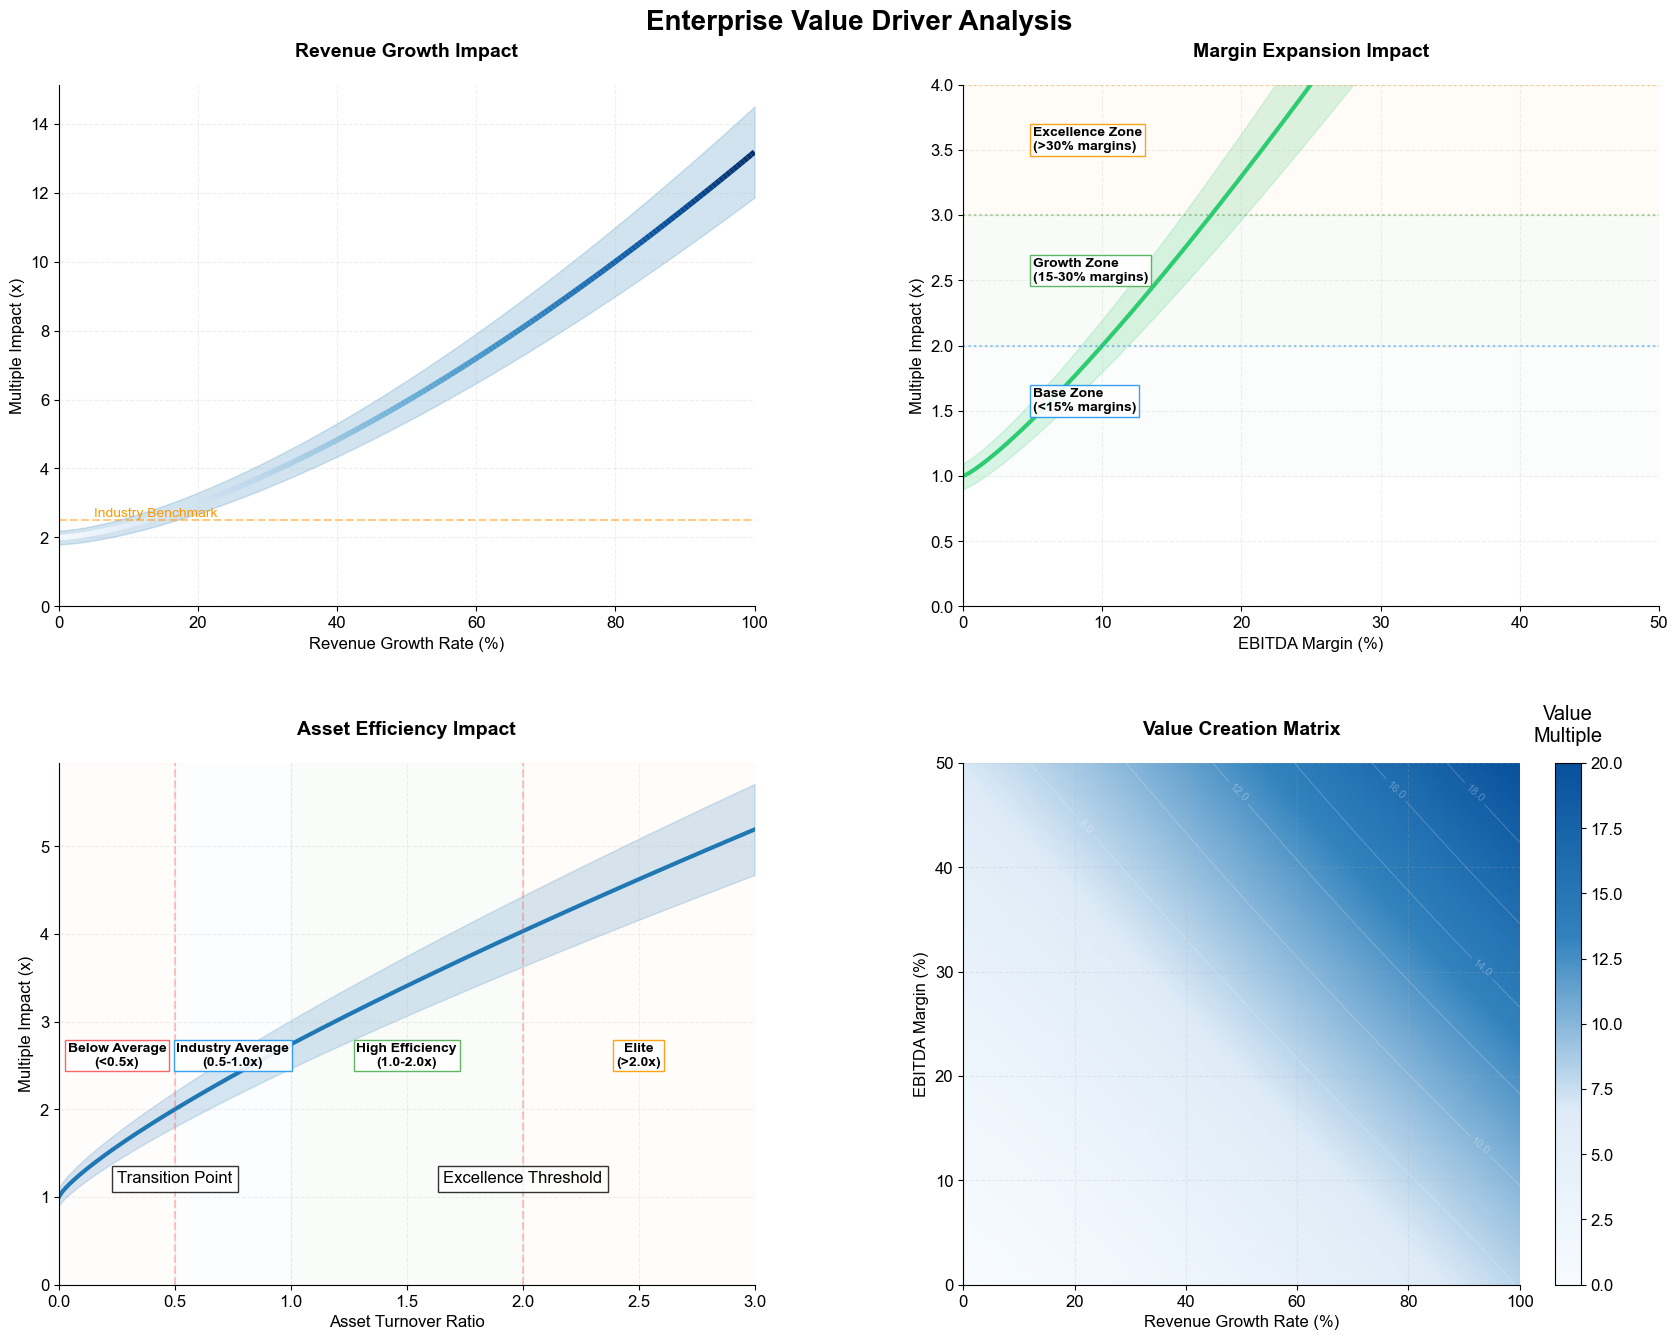

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection

# Premium styling configuration
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [20, 15],
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.grid': True,
    'grid.alpha': 0.2,
    'grid.linestyle': ':',
    'axes.facecolor': '#ffffff',
    'figure.facecolor': '#ffffff',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 12
})

# Create new figure and grid
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Enhanced color palette with more sophisticated gradients
gradient_colors = ['#f7fbff', '#deebf7', '#3182bd', '#08519c']
custom_cmap = LinearSegmentedColormap.from_list('premium', gradient_colors)

# Color definitions
primary_color = '#1f77b4'
secondary_color = '#2ecc71'
accent_color = '#e74c3c'

# 1. Revenue Growth Impact
ax1 = fig.add_subplot(gs[0, 0])
revenue_growth_rates = np.linspace(0, 100, 200)
multiple_expansion = 2 + (revenue_growth_rates/20)**1.5

# Gradient effect for revenue growth
points = np.array([revenue_growth_rates, multiple_expansion]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, 100)
lc = LineCollection(segments, cmap='Blues', norm=norm)
lc.set_array(revenue_growth_rates)
lc.set_linewidth(4)
ax1.add_collection(lc)

# Add confidence bands and updated benchmark line
ax1.fill_between(revenue_growth_rates, multiple_expansion*0.9, multiple_expansion*1.1,
                 alpha=0.2, color=primary_color)
ax1.axhline(y=2.5, color='#FF9800', linestyle='--', alpha=0.5)
ax1.text(5, 2.6, 'Industry Benchmark', fontsize=10, color='#FF9800')

ax1.set_xlabel('Revenue Growth Rate (%)', fontsize=12)
ax1.set_ylabel('Multiple Impact (x)', fontsize=12)


# 2. Margin Expansion Impact with enhanced zones
ax2 = fig.add_subplot(gs[0, 1])
margin_rates = np.linspace(0, 50, 200)
margin_impact = 1 + (margin_rates/10)**1.2

# Main curve with gradient fill
ax2.fill_between(margin_rates, margin_impact*0.9, margin_impact*1.1,
                 alpha=0.2, color=secondary_color)
ax2.plot(margin_rates, margin_impact, color=secondary_color, linewidth=3)

# Enhanced margin zones with gradient effects
margin_zones = [
    (1.0, 2.0, '#E8F4F8', '#2196F3', 'Base Zone'),
    (2.0, 3.0, '#D5E8D4', '#4CAF50', 'Growth Zone'),
    (3.0, 4.0, '#FFE6CC', '#FF9800', 'Excellence Zone')
]

for start, end, fill_color, edge_color, label in margin_zones:
    ax2.axhspan(start, end, alpha=0.15, color=fill_color, label=label)
    ax2.axhline(y=end, color=edge_color, linestyle=':', alpha=0.5)

# Updated zone annotations
zone_labels = [
    (1.5, 'Base Zone\n(<15% margins)', '#2196F3'),
    (2.5, 'Growth Zone\n(15-30% margins)', '#4CAF50'),
    (3.5, 'Excellence Zone\n(>30% margins)', '#FF9800')
]

for y, text, color in zone_labels:
    ax2.annotate(text, xy=(5, y),
                 bbox=dict(facecolor='white', edgecolor=color, alpha=0.9, pad=2),
                 fontsize=10, fontweight='bold')

ax2.set_xlabel('EBITDA Margin (%)', fontsize=12)
ax2.set_ylabel('Multiple Impact (x)', fontsize=12)


# 3. Asset Efficiency Impact with enhanced zones
ax3 = fig.add_subplot(gs[1, 0])
asset_turnover = np.linspace(0, 3, 200)
efficiency_impact = 1 + (asset_turnover/0.5)**0.8

# Main curve with gradient fill
ax3.fill_between(asset_turnover, efficiency_impact*0.9, efficiency_impact*1.1,
                 alpha=0.2, color=primary_color)
ax3.plot(asset_turnover, efficiency_impact, color=primary_color, linewidth=3)

# Define precise efficiency zones
ax3.axvspan(0.0, 0.5, alpha=0.1, color='#FFE6E6', label='Below Average')
ax3.axvspan(0.5, 1.0, alpha=0.1, color='#E8F4F8', label='Industry Average')
ax3.axvspan(1.0, 2.0, alpha=0.1, color='#D5E8D4', label='High Efficiency')
ax3.axvspan(2.0, 3.0, alpha=0.1, color='#FFE6CC', label='Elite Performance')

# Add performance indicators
for x, label in [(0.5, 'Transition Point'), (2.0, 'Excellence Threshold')]:
    ax3.axvline(x=x, color='#FF5252', linestyle='--', alpha=0.3)
    ax3.annotate(label, xy=(x, 1.0), xytext=(0, 10),
                 textcoords='offset points', ha='center',
                 bbox=dict(facecolor='white', alpha=0.8))

# Enhanced zone annotations
efficiency_labels = [
    (0.25, 'Below Average\n(<0.5x)', '#FF5252'),
    (0.75, 'Industry Average\n(0.5-1.0x)', '#2196F3'),
    (1.5, 'High Efficiency\n(1.0-2.0x)', '#4CAF50'),
    (2.5, 'Elite\n(>2.0x)', '#FF9800')
]

for x, text, color in efficiency_labels:
    ax3.annotate(text, xy=(x, 2.5),
                 bbox=dict(facecolor='white', edgecolor=color, alpha=0.9, pad=2),
                 fontsize=10, fontweight='bold', ha='center')

ax3.set_xlabel('Asset Turnover Ratio', fontsize=12)
ax3.set_ylabel('Multiple Impact (x)', fontsize=12)

# 4. Enhanced Combined Impact Matrix
ax4 = fig.add_subplot(gs[1, 1])
x = np.linspace(0, 100, 100)
y = np.linspace(0, 50, 100)
X, Y = np.meshgrid(x, y)
Z = (X/20)**1.3 + (Y/10)**1.2 + (X*Y)/(1000)

im = ax4.pcolormesh(X, Y, Z, cmap=custom_cmap, shading='gouraud')
contours = ax4.contour(X, Y, Z, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax4.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
ax4.set_title('Value Creation Matrix\nGrowth-Margin Synergy', fontsize=14, pad=20, fontweight='bold')

# Set proper axis limits for all plots
ax1.set_xlim(0, 100)
ax1.set_ylim(bottom=0)
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 4.0)
ax3.set_xlim(0, 3)
ax3.set_ylim(bottom=0)
ax4.set_xlim(0, 100)
ax4.set_ylim(0, 50)

# Add titles and labels
titles = ['Revenue Growth Impact', 'Margin Expansion Impact',
          'Asset Efficiency Impact', 'Value Creation Matrix']
for ax, title in zip([ax1, ax2, ax3, ax4], titles):
    ax.set_title(title, fontsize=14, pad=20, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.2)
ax4.set_xlabel('Revenue Growth Rate (%)', fontsize=12)
ax4.set_ylabel('EBITDA Margin (%)', fontsize=12)
# Add colorbar to combined impact plot
cbar = fig.colorbar(im, ax=ax4)
cbar.ax.set_title('Value\nMultiple', pad=15)

# Add main title
fig.suptitle('Enterprise Value Driver Analysis',
             fontsize=20,
             y=0.95,
             fontweight='bold')

# Optimize layout
fig.set_size_inches(20, 15)
fig.subplots_adjust(
    top=0.90,
    bottom=0.10,
    left=0.10,
    right=0.90,
    hspace=0.30,
    wspace=0.30
)

fig.savefig('enterprise_value_analysis1.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()